# Advanced Graph Build


## Filter Master CSV to First 6 Categories

Process:
1. Load the full `master_clauses.csv`.  
2. Select our six clause-of-interest columns (`Parties`, `Agreement Date`, `Effective Date`, `Expiration Date`, `Renewal Term`, `Notice Period To Terminate Renewal`) plus their corresponding “-Answer” fields.  
3. Filter the DataFrame to retain only contracts with at least one non-empty/positive answer.  
4. Reset the index and save the result to `filtered_master_clauses.csv`.


In [4]:
import pandas as pd

# 1. Load the master CSV
df_master = pd.read_csv(r'C:\Repositories\USA_Project\Graph-Test\master_clauses.csv')

# 2. Exact column names for our first six categories:
context_cols = [
    "Parties",
    "Agreement Date",
    "Effective Date",
    "Expiration Date",
    "Renewal Term",
    "Notice Period To Terminate Renewal"
]

# Note the precise answer column names (matching the CSV):
answer_cols = [
    "Parties-Answer",
    "Agreement Date-Answer",
    "Effective Date-Answer",
    "Expiration Date-Answer",
    "Renewal Term-Answer",
    "Notice Period To Terminate Renewal- Answer"
]

# 3. Subset to these columns + Filename
cols_to_keep = ["Filename"] + context_cols + answer_cols
df_sub = df_master[cols_to_keep].copy()

# 4. Filter to rows where at least one answer is non-empty/positive
mask = pd.Series(False, index=df_sub.index)
for ans in answer_cols:
    mask |= df_sub[ans].notna() & ~df_sub[ans].isin(["No", "[]", ""])
df_mini = df_sub[mask].reset_index(drop=True)

# 5. Inspect and save
print(f"Filtered to {len(df_mini)} contracts out of {len(df_master)} total.")
print(df_mini.head())

df_mini.to_csv(r'C:\Repositories\USA_Project\Graph-Test\filtered_master_clauses.csv', index=False)
print("Saved filtered CSV to /mnt/data/mini_cuad_master_first6.csv")


Filtered to 509 contracts out of 510 total.
                                            Filename  \
0  CybergyHoldingsInc_20140520_10-Q_EX-10.27_8605...   
1  EuromediaHoldingsCorp_20070215_10SB12G_EX-10.B...   
2  FulucaiProductionsLtd_20131223_10-Q_EX-10.9_83...   
3  GopageCorp_20140221_10-K_EX-10.1_8432966_EX-10...   
4  IdeanomicsInc_20160330_10-K_EX-10.26_9512211_E...   

                                             Parties  \
0  ['BIRCH FIRST GLOBAL INVESTMENTS INC.', 'MA', ...   
1  ['EuroMedia Holdings Corp.', 'Rogers', 'Rogers...   
2  ['Producer', 'Fulucai Productions Ltd.', 'Conv...   
3  ['PSiTech Corporation', 'Licensor', 'Licensee'...   
4  ['YOU ON DEMAND HOLDINGS, INC.', 'Licensor', '...   

                           Agreement Date  \
0  ['8th day of May 2014', 'May 8, 2014']   
1                      ['July 11 , 2006']   
2                   ['November 15, 2012']   
3                        ['Feb 10, 2014']   
4                   ['December 21, 2015']   

           

## Explode to Clause-Level Snippets

Process:
1. Read `filtered_master_clauses.csv` (contract-level).  
2. Define the six clause context columns.  
3. Iterate over each contract and each context column, extracting non-empty snippets.  
4. Build a snippet-level DataFrame with columns:  
   - `doc_idx` (contract row index)  
   - `filename`  
   - `category`  
   - `snippet_text`  
5. Save the snippet DataFrame to `mini_cuad_snippets.csv`.

Basically for each doc which has a true value for snippet we retrieve the snippet data into a single row.
So if a document has values for multiple clauses , it'll have multiple columns here. These will be the children nodes. While document is the parent node.
Check mini_cuad_snippets.csv

In [5]:
import pandas as pd

# 1. Load the filtered master CSV
df_filtered = pd.read_csv(r'C:\Repositories\USA_Project\Graph-Test\filtered_master_clauses.csv')

# 2. Define the six clause context columns exactly
context_cols = [
    "Parties",
    "Agreement Date",
    "Effective Date",
    "Expiration Date",
    "Renewal Term",
    "Notice Period To Terminate Renewal"
]

# 3. Explode into one row per non-empty snippet
rows = []
for doc_idx, row in df_filtered.reset_index(drop=True).iterrows():
    for cat in context_cols:
        snippet = row[cat]
        if pd.notna(snippet) and snippet not in ["", "No", "[]"]:
            rows.append({
                "doc_idx": doc_idx,
                "filename": row["Filename"],
                "category": cat,
                "snippet_text": snippet.strip()
            })

snips_df = pd.DataFrame(rows)

# 4. Inspect and save
print(f"Extracted {len(snips_df)} snippets:")
print(snips_df.head())

snips_df.to_csv(r'C:\Repositories\USA_Project\Graph-Test\mini_cuad_snippets.csv', index=False)
print("Snippet‐level CSV saved to /mnt/data/mini_cuad_snippets.csv")


Extracted 2069 snippets:
   doc_idx                                           filename  \
0        0  CybergyHoldingsInc_20140520_10-Q_EX-10.27_8605...   
1        0  CybergyHoldingsInc_20140520_10-Q_EX-10.27_8605...   
2        0  CybergyHoldingsInc_20140520_10-Q_EX-10.27_8605...   
3        0  CybergyHoldingsInc_20140520_10-Q_EX-10.27_8605...   
4        0  CybergyHoldingsInc_20140520_10-Q_EX-10.27_8605...   

          category                                       snippet_text  
0          Parties  ['BIRCH FIRST GLOBAL INVESTMENTS INC.', 'MA', ...  
1   Agreement Date             ['8th day of May 2014', 'May 8, 2014']  
2   Effective Date  ['This agreement shall begin upon the date of ...  
3  Expiration Date  ['This agreement shall begin upon the date of ...  
4     Renewal Term  ['This agreement shall begin upon the date of ...  
Snippet‐level CSV saved to /mnt/data/mini_cuad_snippets.csv


## Embed Clause Snippets


1. Load the snippet‐level CSV (`mini_cuad_snippets.csv`) produced in the previous step.  
2. Initialize a legal‐domain SBERT model (`Stern5497/sbert-legal-xlm-roberta-base`).  [Stil testing with this model]
3. Encode each `snippet_text` into a dense vector, storing the result in a new `embedding` column.  
4. Persist the enriched DataFrame to `mini_cuad_snippets_emb.pkl` for downstream graph construction.


In [ ]:
import os
import pandas as pd
from sentence_transformers import SentenceTransformer

# 1. Load snippet table
snips = pd.read_csv(r'C:\Repositories\USA_Project\Graph-Test\mini_cuad_snippets.csv')

# 2. Initialize a legal SBERT model
model = SentenceTransformer('Stern5497/sbert-legal-xlm-roberta-base')

# 3. Embed snippets
snip_texts = snips['snippet_text'].tolist()
snip_embs  = model.encode(snip_texts, show_progress_bar=True)
snips['embedding'] = list(snip_embs)
snips.to_pickle(r'C:\Repositories\USA_Project\Graph-Test\mini_cuad_snippets_emb.pkl')
print(f"Encoded {len(snip_embs)} snippets.")



## Test – Verify TXT File Presence

First tried this, 
1. Load `filtered_master_clauses.csv`.  
2. List all expected PDF filenames.  
3. Check for each whether a corresponding `.txt` exists in `full_contract_txt`, and record its file size.  
4. Display a summary table of existence counts and identify any missing or empty files.

Because of slight mismatch of names like `_` instead of `'`

### Test – Fuzzy Match Basenames
1. List all actual `.txt` basenames in the `full_contract_txt` folder.  
2. For each PDF basename with no direct match, use `difflib.get_close_matches` (cutoff=0.8) to propose the closest `.txt` basename.  
3. Display the mapping suggestions to review and ensure slight naming differences (underscores, punctuation) are handled automatically.




In [8]:
# import os
# import pandas as pd
# from sentence_transformers import SentenceTransformer

# model = SentenceTransformer('Stern5497/sbert-legal-xlm-roberta-base')

# # 4. Embed full contracts
# master   = pd.read_csv(r'C:\Repositories\USA_Project\Graph-Test\filtered_master_clauses.csv')
# files    = master['Filename'].unique()
# BASE_TXT_DIR = r'C:\Repositories\USA_Project\Graph-Test\CUAD_v1\full_contract_txt'


# doc_texts = []
# for fname in files:
#     # Split off the extension (whether .pdf, .PDF, .Pdf, etc.)
#     base, _ = os.path.splitext(fname)
#     txt_name = base + '.txt'
#     txt_path = os.path.join(BASE_TXT_DIR, txt_name)

#     try:
#         with open(txt_path, encoding='utf-8', errors='ignore') as f:
#             doc_texts.append(f.read())
#     except FileNotFoundError:
#         print(f"⚠️  Missing {txt_path}, adding empty text")
#         doc_texts.append("")


# doc_embs = model.encode(doc_texts, show_progress_bar=True)
# docs_df  = pd.DataFrame({'Filename': files, 'embedding': list(doc_embs)})
# docs_df.to_pickle(r'C:\Repositories\USA_Project\Graph-Test\mini_cuad_docs_emb.pkl')
# print(f"Encoded {len(doc_embs)} documents.")

In [ ]:
# import os
# import pandas as pd

# # Adjust to your local paths
# filtered_csv = r'C:\Repositories\USA_Project\Graph-Test\filtered_master_clauses.csv'
# BASE_TXT_DIR = r'C:\Repositories\USA_Project\Graph-Test\CUAD_v1\full_contract_txt'

# master = pd.read_csv(filtered_csv)
# files = master['Filename'].unique().tolist()

# checks = []
# for fname in files:
#     base, _ = os.path.splitext(fname)
#     txt_name = base + '.txt'
#     txt_path = os.path.join(BASE_TXT_DIR, txt_name)
#     exists = os.path.exists(txt_path)
#     size = os.path.getsize(txt_path) if exists else 0
#     checks.append({'Filename': fname, 'TxtName': txt_name, 'Exists': exists, 'SizeBytes': size})

# df_checks = pd.DataFrame(checks)
# print(df_checks.head(20))
# print("\nExistence counts:\n", df_checks['Exists'].value_counts())
# print("\nMissing files:\n", df_checks.loc[~df_checks['Exists'], 'TxtName'].tolist())


                                             Filename  \
0   CybergyHoldingsInc_20140520_10-Q_EX-10.27_8605...   
1   EuromediaHoldingsCorp_20070215_10SB12G_EX-10.B...   
2   FulucaiProductionsLtd_20131223_10-Q_EX-10.9_83...   
3   GopageCorp_20140221_10-K_EX-10.1_8432966_EX-10...   
4   IdeanomicsInc_20160330_10-K_EX-10.26_9512211_E...   
5   DeltathreeInc_19991102_S-1A_EX-10.19_6227850_E...   
6   EdietsComInc_20001030_10QSB_EX-10.4_2606646_EX...   
7   IntegrityMediaInc_20010329_10-K405_EX-10.17_23...   
8   MusclepharmCorp_20170208_10-KA_EX-10.38_989358...   
9   TomOnlineInc_20060501_20-F_EX-4.46_749700_EX-4...   
10  ConformisInc_20191101_10-Q_EX-10.6_11861402_EX...   
11  EtonPharmaceuticalsInc_20191114_10-Q_EX-10.1_1...   
12  FuelcellEnergyInc_20191106_8-K_EX-10.1_1186800...   
13  ReedsInc_20191113_10-Q_EX-10.4_11888303_EX-10....   
14  FuseMedicalInc_20190321_10-K_EX-10.43_11575454...   
15  GentechHoldingsInc_20190808_1-A_EX1A-6 MAT CTR...   
16  ImineCorp_20180725_S-1_EX-1

## Final Load & Embed Contracts with Automatic Mapping

1. Build an in-memory mapping from each PDF basename to the best matching TXT basename (exact or fuzzy).  
2. Load each contract’s text via that mapping (falling back to `""` if still unmatched).  
3. Encode all contract texts with the legal SBERT model `Stern5497/sbert-legal-xlm-roberta-base`.  
4. Save the resulting DataFrame of (`Filename`, `embedding`) to `mini_cuad_docs_emb.pkl`.


In [ ]:
import os
import difflib
import pandas as pd
from sentence_transformers import SentenceTransformer

# ── CONFIGURE THESE THREE PATHS ────────────────────────────────
CSV_PATH    = r'C:\Repositories\USA_Project\Graph-Test\filtered_master_clauses.csv'
TXT_FOLDER  = r'C:\Repositories\USA_Project\Graph-Test\CUAD_v1\full_contract_txt'
OUTPUT_PKL  = r'C:\Repositories\USA_Project\Graph-Test\mini_cuad_docs_emb.pkl'
# ────────────────────────────────────────────────────────────────

# 1. Load the list of filenames from your filtered master CSV
df_master = pd.read_csv(CSV_PATH)
pdf_files = df_master['Filename'].unique().tolist()

# 2. List the actual .txt files on disk and strip off their extensions
all_txt = os.listdir(TXT_FOLDER)
txt_basenames = {os.path.splitext(f)[0]: f for f in all_txt}

# 3. Build a mapping PDF-basename → TXT-basename (fuzzy match if needed)
mapping = {}
for pdf in pdf_files:
    base, _ = os.path.splitext(pdf)            
    if base in txt_basenames:
        mapping[base] = base                     # exact match
    else:
        # find the single best match above a 0.8 similarity threshold
        candidates = difflib.get_close_matches(base, txt_basenames.keys(), n=1, cutoff=0.8)
        mapping[base] = candidates[0] if candidates else None

# (Optional) print out any that still didn’t match
unmatched = [b for b,m in mapping.items() if m is None]
if unmatched:
    print(" No .txt match for these basenames:")
    for u in unmatched:
        print("   ", u)

# 4. Load each contract’s text via the mapping
docs_texts = []
for pdf in pdf_files:
    base, _ = os.path.splitext(pdf)
    txt_base = mapping.get(base)
    if txt_base:
        path = os.path.join(TXT_FOLDER, txt_base + '.txt')
        try:
            with open(path, encoding='utf-8', errors='ignore') as f:
                docs_texts.append(f.read())
        except Exception as e:
            print(f"Failed reading {path}: {e}")
            docs_texts.append("")
    else:
        # no good match found
        docs_texts.append("")
        
df_checks = pd.DataFrame(docs_texts)
print(df_checks.head(20))
rows, cols = df_checks.shape
print(f"There are {rows} rows and {cols} columns.")




                                                    0
0   Exhibit 10.27\n\nMARKETING AFFILIATE AGREEMENT...
1   Exhibit 10.B.01 EXECUTION COPY\n\nVIDEO-ON-DEM...
2   CONTENT DISTRIBUTION AND LICENSE AGREEMENT   D...
3   CONFIDENTIAL\n\n  PSiTECHCORPORATION   WEBSITE...
4   CONTENT LICENSE AGREEMENT\n\nTHIS CONTENT LICE...
5   Execution Copy\n\n                       CO-BR...
6   EXHIBIT 10.4\n\n                              ...
7   1                                             ...
8   ENDORSEMENT LICENSING AND CO-BRANDING AGREEMEN...
9   Exhibit 4.46     6 rue Adolphe Fischer L-1520 ...
10  Execution Version Certain identified informati...
11  Exhibit 10.1 Certain information identified by...
12  EXHIBIT 10.1\n\nJOINT DEVELOPMENT AGREEMENT\n\...
13  RECIPE DEVELOPMENT AGREEMENT This Recipe Devel...
14  EXHIBIT 10.43 Dated 29/3/18\n\nDistributorship...
15  Exhibit 6.1 DISTRIBUTOR AGREEMENT THIS DISTRIB...
16  EXHIBIT 10.5 NON-EXCLUSIVE DISTRIBUTOR AGREEME...
17  Exhibit 10.6 ATTACHMENT 

In [ ]:
# 5. Embed with SBERT
model     = SentenceTransformer('Stern5497/sbert-legal-xlm-roberta-base')
doc_embs  = model.encode(docs_texts, show_progress_bar=True)

# 6. Save to disk
output_df = pd.DataFrame({
    'Filename': pdf_files,
    'embedding': list(doc_embs)
})
output_df.to_pickle(OUTPUT_PKL)
print(f"Encoded {len(doc_embs)} documents and saved to {OUTPUT_PKL}")

In [1]:
import os
import shutil

# Define your paths
pdf_root = r'C:\Repositories\USA_Project\Graph-Test\CUAD_v1\full_contract_pdf\test'
txt_root = r'C:\Repositories\USA_Project\Graph-Test\CUAD_v1\full_contract_txt'  # where all .txts currently are
target_root = r'C:\Repositories\USA_Project\Graph-Test\CUAD_v1\chunk_input'  # where you want structured folders

# Create the target root if it doesn't exist
os.makedirs(target_root, exist_ok=True)

# Go through each category
for category in os.listdir(pdf_root):
    category_path = os.path.join(pdf_root, category)
    
    if not os.path.isdir(category_path):
        continue

    # Make output folder for this category
    category_target_folder = os.path.join(target_root, category)
    os.makedirs(category_target_folder, exist_ok=True)

    # Go through each PDF file
    for file in os.listdir(category_path):
        if not file.lower().endswith('.pdf'):
            continue

        base_name = os.path.splitext(file)[0]
        txt_file = base_name + '.txt'
        txt_path = os.path.join(txt_root, txt_file)

        if os.path.exists(txt_path):
            dest_path = os.path.join(category_target_folder, txt_file)
            shutil.copy2(txt_path, dest_path)
        else:
            print(f"❌ Missing text file for {file}")


In [4]:
import os
import re
import pandas as pd
from tqdm import tqdm

def preprocess_legal_text(text):
    """Clean and normalize legal text."""
    # Remove excessive whitespace
    text = re.sub(r'\s+', ' ', text)
    
    # Remove line numbers or article numbers like "1.1", "Section 2", etc. (optional)
    text = re.sub(r'\b(Section|Article)?\s?\d+(\.\d+)*[:.)]?\s+', '', text, flags=re.IGNORECASE)
    
    # Normalize special unicode quotes and dashes
    text = text.replace('“', '"').replace('”', '"').replace('–', '-').replace('—', '-')
    
    # Remove page headers/footers if repeating
    lines = text.split('\n')
    lines = [line.strip() for line in lines if line.strip()]
    
    return ' '.join(lines).strip()

def load_documents_from_text_folder(base_dir):
    """
    Load and preprocess text files from subfolders in base_dir. 
    Each subfolder is a document category.
    
    Returns a DataFrame with columns: id, name, category, text, file_path
    """
    documents = []
    doc_id = 0

    print(f"Loading documents from: {base_dir}\n")

    for category in sorted(os.listdir(base_dir)):
        category_path = os.path.join(base_dir, category)
        if not os.path.isdir(category_path):
            continue
        
        category_doc_count = 0
        
        for fname in os.listdir(category_path):
            if not fname.endswith(".txt"):
                continue
            
            file_path = os.path.join(category_path, fname)
            try:
                with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                    raw_text = f.read()
                    cleaned_text = preprocess_legal_text(raw_text)
                    
                    if len(cleaned_text.split()) < 50:
                        print(f"Skipping too-short file: {fname}")
                        continue
                    
                    documents.append({
                        'id': doc_id,
                        'name': os.path.splitext(fname)[0],
                        'category': category,
                        'text': cleaned_text,
                        'file_path': file_path
                    })
                    doc_id += 1
                    category_doc_count += 1
                    
            except Exception as e:
                print(f" Error reading {file_path}: {e}")
        
        print(f" Loaded {category_doc_count} documents from category: {category}")

    docs_df = pd.DataFrame(documents)
    print(f"\n Total Documents Loaded: {len(docs_df)} across {docs_df['category'].nunique()} categories.")
    return docs_df


In [5]:
base_dir = r"C:\Repositories\USA_Project\Graph-Test\CUAD_v1\chunk_input"
docs_df = load_documents_from_text_folder(base_dir)



Loading documents from: C:\Repositories\USA_Project\Graph-Test\CUAD_v1\chunk_input

 Loaded 33 documents from category: License_Agreements
 Loaded 34 documents from category: Maintenance
 Loaded 28 documents from category: Service
 Loaded 31 documents from category: Sponsorship
 Loaded 32 documents from category: Strategic Alliance

 Total Documents Loaded: 158 across 5 categories.


In [7]:
print(docs_df.head())  # Shows the first 5 rows


   id                                               name            category  \
0   0  AlliedEsportsEntertainmentInc_20190815_8-K_EX-...  License_Agreements   
1   1  ArconicRolledProductsCorp_20191217_10-12B_EX-2...  License_Agreements   
2   2  ArtaraTherapeuticsInc_20200110_8-K_EX-10.5_119...  License_Agreements   
3   3  ChinaRealEstateInformationCorp_20090929_F-1_EX...  License_Agreements   
4   4  CytodynInc_20200109_10-Q_EX-10.5_11941634_EX-1...  License_Agreements   

                                                text  \
0  ExhibitJOINT CONTENT LICENSE AGREEMENT This JO...   
1  ExhibitFORM OF TRADEMARK LICENSE AGREEMENT THI...   
2  ExhibitCERTAIN CONFIDENTIAL INFORMATION CONTAI...   
3  ExhibitEXECUTION VERSION CONFIDENTIAL DOMAIN N...   
4  ExhibitCertain identified information has been...   

                                           file_path  
0  C:\Repositories\USA_Project\Graph-Test\CUAD_v1...  
1  C:\Repositories\USA_Project\Graph-Test\CUAD_v1...  
2  C:\Repositorie

In [8]:
print(docs_df.info())  # Shows the DataFrame structure and types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         158 non-null    int64 
 1   name       158 non-null    object
 2   category   158 non-null    object
 3   text       158 non-null    object
 4   file_path  158 non-null    object
dtypes: int64(1), object(4)
memory usage: 6.3+ KB
None


In [ ]:
import re
import pandas as pd
from tqdm import tqdm

def optimized_hybrid_chunking(docs_df, semantic_min_size=150, semantic_max_size=400,
                             hierarchical_levels=[400, 800], position_importance=True):
    """
    Optimized hybrid chunking combining semantic boundaries with hierarchical representation
    for both search and graph neural network applications.
    """
    chunks = []
    chunk_id_counter = 0 # Use a single counter

    section_patterns = [
        r'(?i)(?:\n|\s{2,})(?:section|article)\s+\d+[\.\:]\s+[A-Z]',
        r'\n[A-Z][A-Z\s]+(?:\n|\s{2,})',
        r'(?:\n|\s{2,})(?:\d+\.\d+|\d+\.)\s+[A-Z]',
        r'(?i)(?:\n|\s{2,})(?:DEFINITIONS|DEFINED TERMS)(?:\n|\s{2,})',
        r'(?:\n|\s{2,})(?:WHEREAS:|IN WITNESS WHEREOF:|NOW, THEREFORE,)',
        r'(?i)(?:\n|\s{2,})(?:RECITALS|WITNESSETH|APPENDIX|EXHIBIT|SCHEDULE|ANNEX)\s+[A-Za-z0-9]'
    ]
    compiled_patterns = [re.compile(pattern) for pattern in section_patterns]

    for _, doc in tqdm(docs_df.iterrows(), total=len(docs_df), desc="Creating hybrid chunks"):
        doc_id_val = doc['id']
        text = doc['text']
        
        # Create word to character offset mapping for the current document
        doc_text_words = text.split() # Based on how preprocess_legal_text works
        char_start_offsets_for_words = [0] * len(doc_text_words)
        current_char_offset = 0
        # This simple split & find might be fragile if text has complex whitespace.
        # preprocess_legal_text aims to normalize this.
        temp_text_for_offsets = text
        for i, word in enumerate(doc_text_words):
            try:
                word_pos = temp_text_for_offsets.find(word)
                char_start_offsets_for_words[i] = current_char_offset + word_pos
                advance_offset = word_pos + len(word)
                current_char_offset += advance_offset
                temp_text_for_offsets = temp_text_for_offsets[advance_offset:]
            except Exception: # Fallback if find fails unexpectedly
                 if i > 0: char_start_offsets_for_words[i] = char_start_offsets_for_words[i-1] + len(doc_text_words[i-1]) + 1
                 else: char_start_offsets_for_words[i] = 0


        doc_chunks_meta_l1 = [] # Store L1 chunk metadata for this doc

        # STEP 1: Create semantic boundaries
        boundaries = [0]
        for pattern in compiled_patterns:
            for match in pattern.finditer(text):
                boundaries.append(match.start())
        paragraph_breaks = [m.start() for m in re.finditer(r'\n\s*\n', text)]
        boundaries.extend(paragraph_breaks)
        boundaries.append(len(text))
        boundaries = sorted(list(set(boundaries)))

        # STEP 2: Create initial semantic_chunks (L1 precursor)
        raw_semantic_chunks = []
        special_sections = {'definitions': None, 'termination': None, 'confidentiality': None, 'indemnification': None}
        
        for i in range(len(boundaries) - 1):
            chunk_text = text[boundaries[i]:boundaries[i+1]].strip()
            if not chunk_text: continue

            lower_text = chunk_text.lower()
            for section_type_key in special_sections:
                if section_type_key in lower_text and len(chunk_text.split()) > 20: # Arbitrary length
                    if special_sections[section_type_key] is None: # Mark first occurrence
                       special_sections[section_type_key] = len(raw_semantic_chunks) 

            total_initial_chunks = len(boundaries) - 1
            position_val = "middle"
            position_score_val = 0.8 if position_importance else 0.7
            if total_initial_chunks > 0 : # Avoid division by zero
                if i < total_initial_chunks * 0.2:
                    position_val = "beginning"; position_score_val = 0.95 if position_importance else 0.7
                elif i > total_initial_chunks * 0.8:
                    position_val = "end"; position_score_val = 0.7 if position_importance else 0.7
            
            raw_semantic_chunks.append({
                'text': chunk_text, 'start_idx': boundaries[i], 'end_idx': boundaries[i+1],
                'position': position_val, 'position_score': position_score_val, 'original_idx': i
            })

        # STEP 3: Process L1 chunk sizes
        processed_l1_chunks = []
        idx_raw_sem = 0
        while idx_raw_sem < len(raw_semantic_chunks):
            chunk = raw_semantic_chunks[idx_raw_sem]
            words = chunk['text'].split()

            if len(words) < semantic_min_size and idx_raw_sem < len(raw_semantic_chunks) - 1:
                next_chunk = raw_semantic_chunks[idx_raw_sem + 1]
                combined_text = chunk['text'] + " " + next_chunk['text'] # Simple space join
                if len(combined_text.split()) <= semantic_max_size:
                    # Merge chunk with next_chunk
                    raw_semantic_chunks[idx_raw_sem + 1]['text'] = combined_text
                    raw_semantic_chunks[idx_raw_sem + 1]['start_idx'] = chunk['start_idx']
                    # Position/score of the merged chunk could be re-evaluated or taken from the first.
                    # For simplicity, next_chunk's original position info is largely kept, but start_idx is updated.
                    idx_raw_sem += 1 # Skip current chunk as it's merged into next
                    continue
            
            if len(words) > semantic_max_size:
                # Try natural sub-divisions first
                sub_texts_natural = re.split(r'\n\s*\n', chunk['text'])
                if len(sub_texts_natural) > 1 and all(len(t.split()) < semantic_max_size for t in sub_texts_natural if t.strip()):
                    current_char_offset_in_chunk = 0
                    for sub_idx, sub_text_natural in enumerate(sub_texts_natural):
                        sub_text_natural = sub_text_natural.strip()
                        if not sub_text_natural: continue
                        
                        sub_pos = chunk['position']
                        sub_score = chunk['position_score']
                        if sub_idx > 0 : sub_score = max(0.6, chunk['position_score'] - 0.1 * sub_idx)

                        processed_l1_chunks.append({
                            'text': sub_text_natural,
                            'start_idx': chunk['start_idx'] + current_char_offset_in_chunk,
                            'end_idx': chunk['start_idx'] + current_char_offset_in_chunk + len(sub_text_natural),
                            'position': sub_pos, 'position_score': sub_score, 
                            'parent_original_idx': chunk.get('original_idx', -1)
                        })
                        current_char_offset_in_chunk += len(sub_text_natural) + (len(chunk['text']) - current_char_offset_in_chunk - len(sub_text_natural) > 0) # Approx for separator
                else: # Forced splits
                    current_word_idx_in_chunk = 0
                    chunk_words = chunk['text'].split() # Words of the current large L1 chunk
                    
                    # Create char offsets for words within this specific chunk['text']
                    offsets_in_chunk_text = [0] * len(chunk_words)
                    temp_chunk_text_ptr = 0
                    search_text_segment = chunk['text']
                    for i_cw, cw in enumerate(chunk_words):
                        try:
                            pos_cw = search_text_segment.find(cw)
                            offsets_in_chunk_text[i_cw] = temp_chunk_text_ptr + pos_cw
                            adv = pos_cw + len(cw)
                            temp_chunk_text_ptr += adv
                            search_text_segment = search_text_segment[adv:]
                        except: # Fallback
                            if i_cw > 0: offsets_in_chunk_text[i_cw] = offsets_in_chunk_text[i_cw-1] + len(chunk_words[i_cw-1]) + 1
                            else: offsets_in_chunk_text[i_cw] = 0


                    while current_word_idx_in_chunk < len(chunk_words):
                        sub_chunk_words = chunk_words[current_word_idx_in_chunk : current_word_idx_in_chunk + semantic_max_size]
                        if not sub_chunk_words: break
                        
                        sub_text_forced = " ".join(sub_chunk_words) # Reconstruct with single spaces

                        # Determine char start/end for this sub_text_forced within original document
                        sub_chunk_char_start_in_chunktext = offsets_in_chunk_text[current_word_idx_in_chunk]
                        
                        # End is start of last word + len of last word
                        idx_of_last_word_in_sub_chunk = current_word_idx_in_chunk + len(sub_chunk_words) - 1
                        sub_chunk_char_end_in_chunktext = offsets_in_chunk_text[idx_of_last_word_in_sub_chunk] + len(chunk_words[idx_of_last_word_in_sub_chunk])


                        sub_pos = chunk['position']
                        sub_score = chunk['position_score']
                        if current_word_idx_in_chunk > 0 : sub_score = max(0.6, chunk['position_score'] - 0.1)

                        processed_l1_chunks.append({
                            'text': sub_text_forced,
                            'start_idx': chunk['start_idx'] + sub_chunk_char_start_in_chunktext,
                            'end_idx': chunk['start_idx'] + sub_chunk_char_end_in_chunktext,
                            'position': sub_pos, 'position_score': sub_score,
                            'parent_original_idx': chunk.get('original_idx', -1)
                        })
                        current_word_idx_in_chunk += len(sub_chunk_words)
            else: # Chunk size is acceptable
                processed_l1_chunks.append(chunk)
            idx_raw_sem += 1
            
        # STEP 4: Create final L1 chunks and then hierarchical chunks (L2+)
        doc_all_level_chunks = []

        # Add L1 (semantic) chunks
        for l1_chunk_data in processed_l1_chunks:
            is_special = False
            special_type_name = None
            parent_orig_idx = l1_chunk_data.get('parent_original_idx', l1_chunk_data.get('original_idx'))

            for sec_type, orig_idx in special_sections.items():
                if orig_idx is not None and parent_orig_idx == orig_idx:
                    is_special = True
                    special_type_name = sec_type
                    break
            
            current_chunk_id = chunk_id_counter
            final_l1_chunk = {
                'chunk_id': current_chunk_id, 'doc_id': doc_id_val, 'doc_name': doc['name'],
                'category': doc['category'], 'text': l1_chunk_data['text'],
                'chunk_method': 'semantic', 'level': 'L1',
                'start_idx': l1_chunk_data['start_idx'], 'end_idx': l1_chunk_data['end_idx'],
                'document_position': l1_chunk_data['position'], 'position_score': l1_chunk_data['position_score'],
                'is_special_section': is_special
            }
            if is_special: final_l1_chunk['section_type'] = special_type_name
            
            doc_all_level_chunks.append(final_l1_chunk)
            doc_chunks_meta_l1.append({ # For L2+ contained_chunks logic
                'chunk_id': current_chunk_id,
                'char_start_idx': l1_chunk_data['start_idx'], # Char idx
                'char_end_idx': l1_chunk_data['end_idx']      # Char idx
            })
            chunk_id_counter += 1

        # Add L2+ (hierarchical) chunks
        for level_idx, hier_chunk_size_words in enumerate(hierarchical_levels):
            level_name = f"L{level_idx + 2}"
            if len(doc_text_words) < hier_chunk_size_words * 1.5: continue # Skip if doc too short for this level

            overlap_words = min(hier_chunk_size_words // 4, 50)
            
            for i_word_hier in range(0, len(doc_text_words), hier_chunk_size_words - overlap_words):
                hier_sub_words = doc_text_words[i_word_hier : i_word_hier + hier_chunk_size_words]
                if len(hier_sub_words) < hier_chunk_size_words // 3 : continue

                hier_text = " ".join(hier_sub_words)
                
                # Hierarchical chunk boundaries in characters
                hier_char_start = char_start_offsets_for_words[i_word_hier]
                idx_last_word_in_hier = i_word_hier + len(hier_sub_words) -1
                hier_char_end = char_start_offsets_for_words[idx_last_word_in_hier] + len(doc_text_words[idx_last_word_in_hier]) if idx_last_word_in_hier < len(doc_text_words) else len(text)


                pos_hier = "middle"; score_hier = 0.75 if position_importance else 0.7
                total_hier_chunks_at_level = max(1, (len(doc_text_words) - hier_chunk_size_words) // (hier_chunk_size_words - overlap_words) +1)
                current_hier_chunk_index = i_word_hier // (hier_chunk_size_words-overlap_words)
                if total_hier_chunks_at_level > 0:
                    if current_hier_chunk_index < total_hier_chunks_at_level / 3:
                        pos_hier = "beginning"; score_hier = 0.85 if position_importance else 0.7
                    elif current_hier_chunk_index > 2 * total_hier_chunks_at_level / 3:
                        pos_hier = "end"; score_hier = 0.7 if position_importance else 0.7
                
                contained_l1_ids = []
                for l1_meta in doc_chunks_meta_l1:
                    # Check for overlap: max(start1, start2) < min(end1, end2)
                    if max(hier_char_start, l1_meta['char_start_idx']) < min(hier_char_end, l1_meta['char_end_idx']):
                        contained_l1_ids.append(l1_meta['chunk_id'])
                
                current_chunk_id = chunk_id_counter
                doc_all_level_chunks.append({
                    'chunk_id': current_chunk_id, 'doc_id': doc_id_val, 'doc_name': doc['name'],
                    'category': doc['category'], 'text': hier_text,
                    'chunk_method': 'hierarchical', 'level': level_name, 'level_size': hier_chunk_size_words,
                    'start_idx': hier_char_start, # Store char indices for consistency if preferred
                    'end_idx': hier_char_end,     # Or store word indices i_word_hier, i_word_hier + len(hier_sub_words)
                    'document_position': pos_hier, 'position_score': score_hier,
                    'contained_chunks': contained_l1_ids # List of L1 chunk IDs
                })
                chunk_id_counter += 1
        
        # Full document chunk for small documents
        # Consider adjusting this threshold if you want to change how medium-sized documents are handled
        if len(doc_text_words) < 1000: # Arbitrary threshold, potentially increase if desired
            current_chunk_id = chunk_id_counter
            doc_all_level_chunks.append({
                'chunk_id': current_chunk_id, 'doc_id': doc_id_val, 'doc_name': doc['name'],
                'category': doc['category'], 'text': text,
                'chunk_method': 'full_document', 'level': 'full',
                'start_idx': 0, 'end_idx': len(text),
                'document_position': 'complete', 'position_score': 1.0,
                'contained_chunks': [m['chunk_id'] for m in doc_chunks_meta_l1]
            })
            chunk_id_counter +=1
            
        chunks.extend(doc_all_level_chunks)

    chunks_df = pd.DataFrame(chunks)
    
    if not chunks_df.empty:
        # Add chunk_relationships
        # This can be slow on very large dataframes.
        # Pre-calculating lookups or using groupby could optimize if needed.
        
        # Create a lookup for L1 chunks per document
        l1_chunks_by_doc = {}
        if 'level' in chunks_df.columns and 'doc_id' in chunks_df.columns and 'chunk_id' in chunks_df.columns:
             l1_chunks_by_doc = chunks_df[chunks_df['level'] == 'L1'].groupby('doc_id')['chunk_id'].apply(list).to_dict()

        # Create a lookup for hierarchical parents
        # A L1 chunk's parents are L2+ chunks that contain it.
        hier_parents_lookup = {} # Key: L1_chunk_id, Value: list of L2+_chunk_ids
        if 'contained_chunks' in chunks_df.columns and 'chunk_method' in chunks_df.columns:
            for _, row in chunks_df.iterrows():
                if row['chunk_method'] == 'hierarchical' or row['chunk_method'] == 'full_document':
                    if isinstance(row['contained_chunks'], list):
                        for l1_child_id in row['contained_chunks']:
                            if l1_child_id not in hier_parents_lookup:
                                hier_parents_lookup[l1_child_id] = []
                            hier_parents_lookup[l1_child_id].append(row['chunk_id'])
        
        def get_relationships(row):
            rels = {'same_doc_l1_chunks': [], 'hierarchical_parents': []}
            if row['level'] == 'L1': # Relationships primarily defined for L1 nodes
                # Same document L1 chunks (excluding self)
                rels['same_doc_l1_chunks'] = [cid for cid in l1_chunks_by_doc.get(row['doc_id'], []) if cid != row['chunk_id']]
                # Hierarchical parents
                rels['hierarchical_parents'] = hier_parents_lookup.get(row['chunk_id'], [])
            return rels
            
        chunks_df['chunk_relationships'] = chunks_df.apply(get_relationships, axis=1)

    print(f"Created {len(chunks_df)} hybrid chunks from {len(docs_df)} documents")
    return chunks_df


Creating hybrid chunks:   0%|          | 0/158 [00:00<?, ?it/s]

Creating hybrid chunks: 100%|██████████| 158/158 [00:14<00:00, 10.90it/s]



Created 6434 hybrid chunks from 158 documents
Selected hybrid chunking with 6434 chunks for further processing.


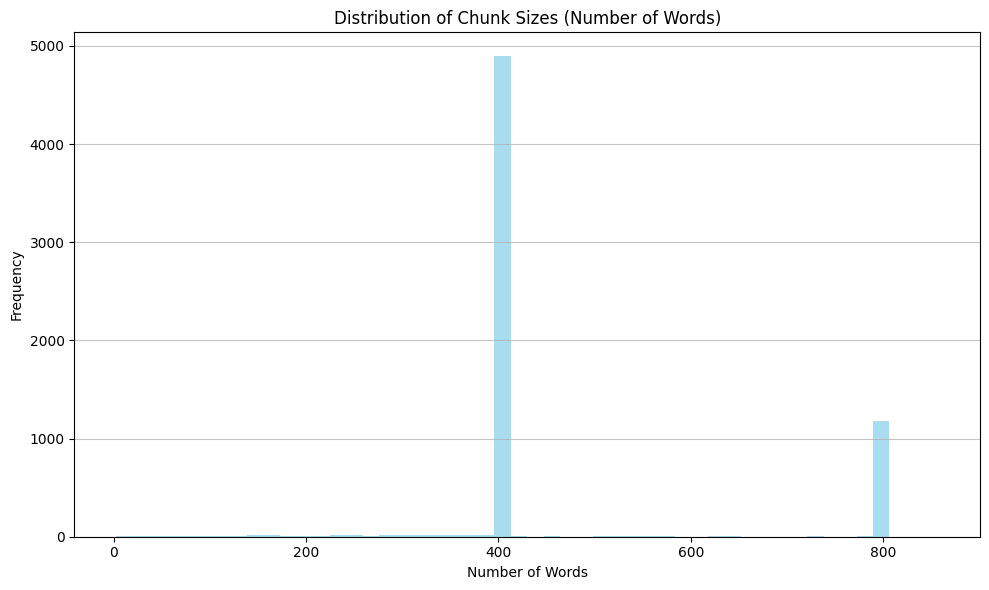

C:\Users\Thevindu Kalubowila\AppData\Local\Temp\ipykernel_15636\3780392110.py:32: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


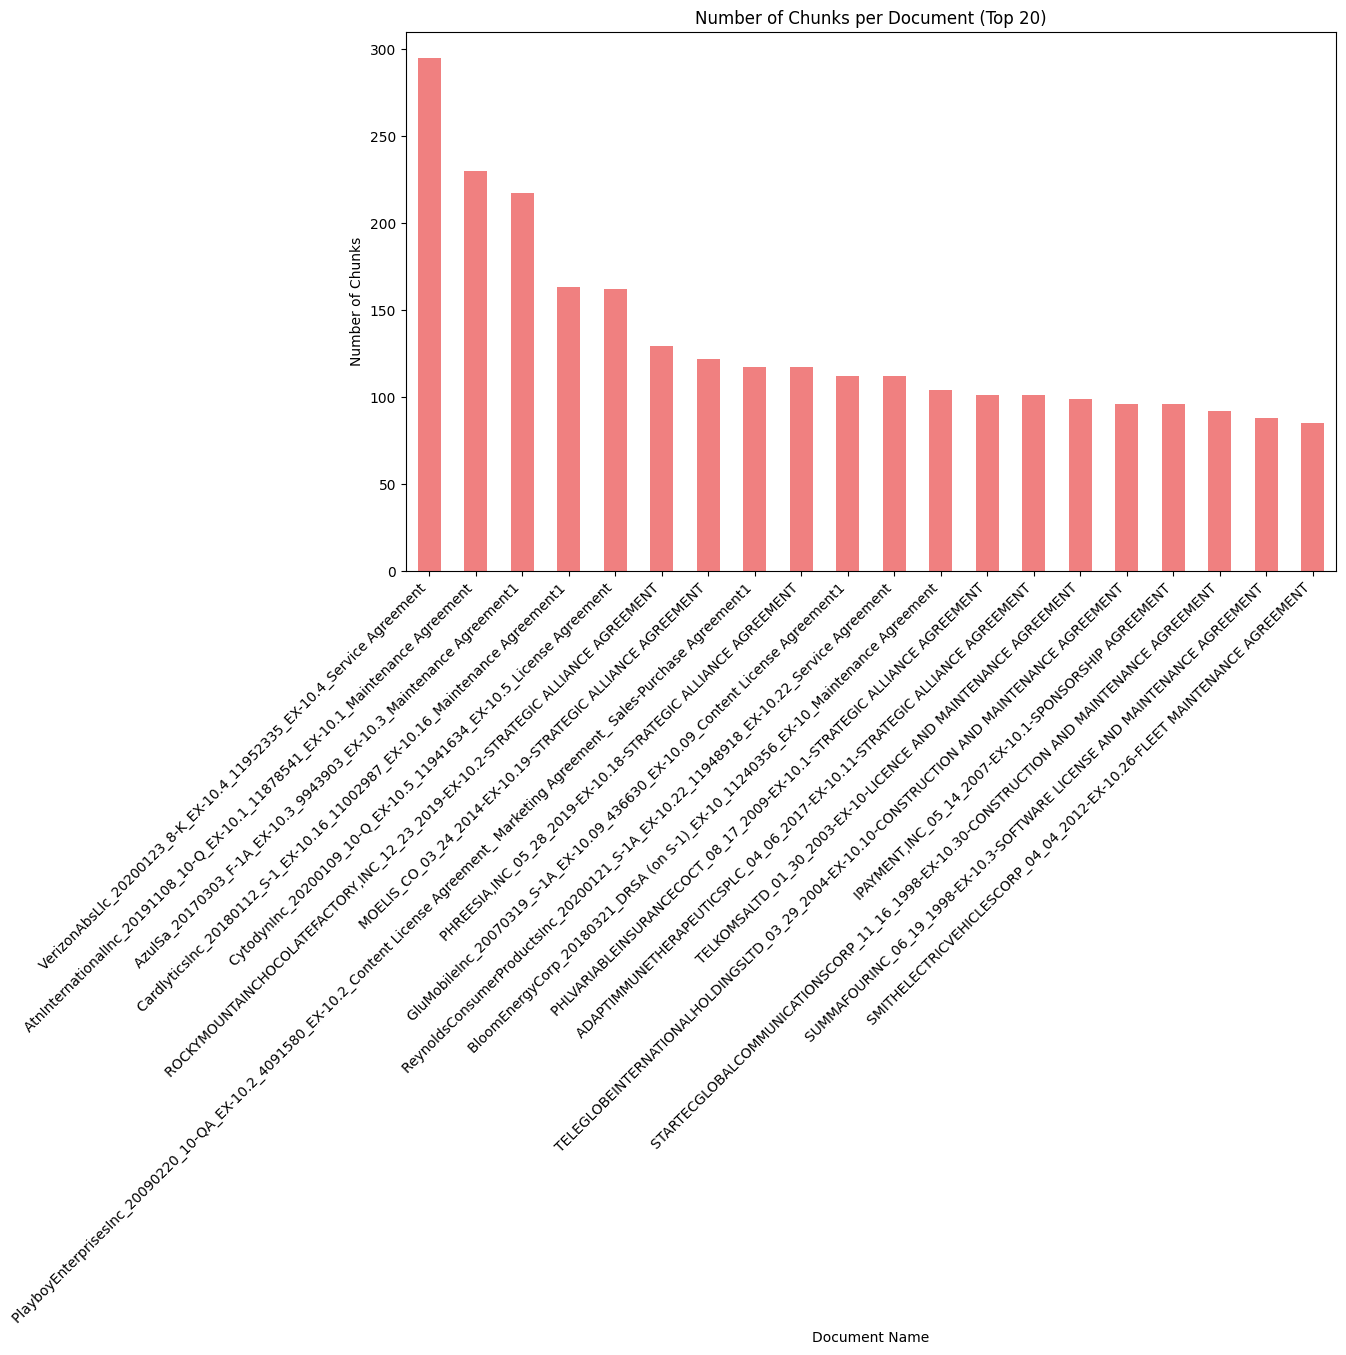

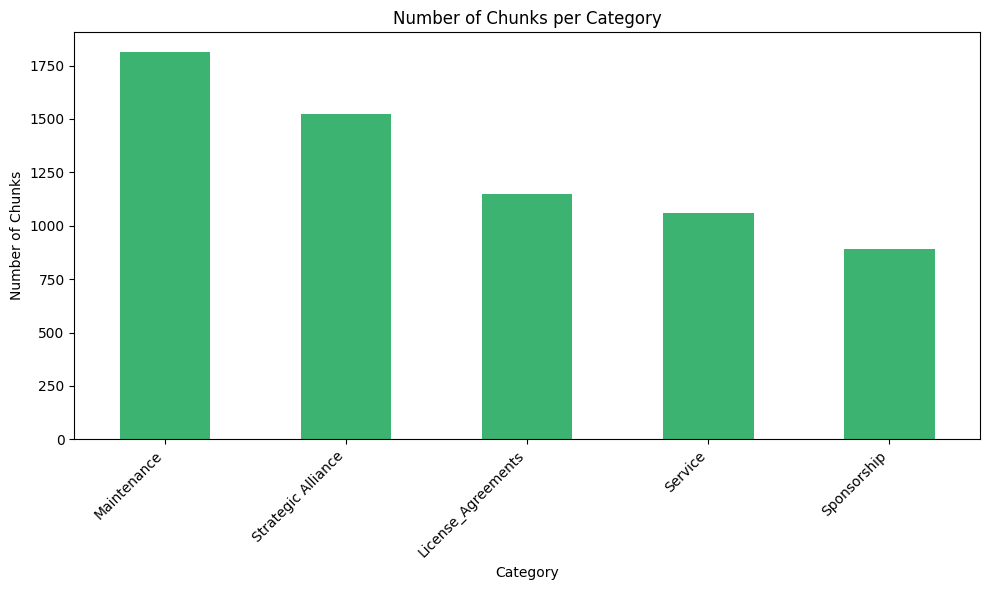

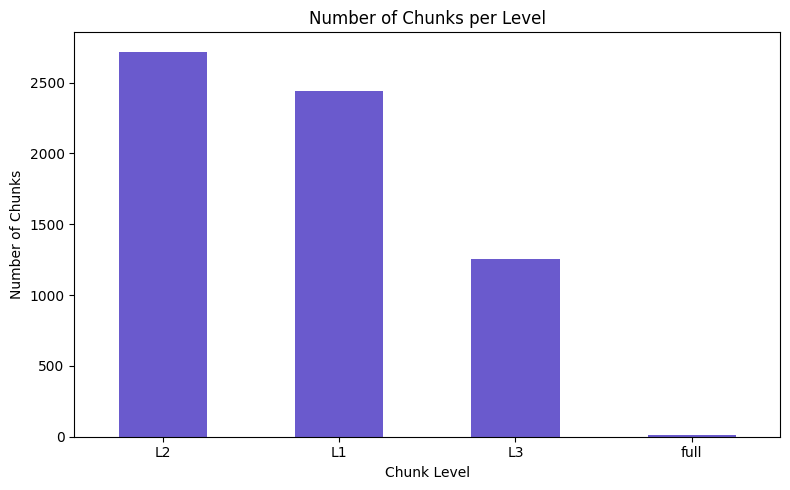

In [13]:
# Assuming docs_df is loaded and preprocessed as in your script
# docs_df = load_documents_from_text_folder("your_base_dir_here")

if docs_df is not None and not docs_df.empty:
    hybrid_chunks_df = optimized_hybrid_chunking(docs_df)
    
    if not hybrid_chunks_df.empty:
        print(f"Selected hybrid chunking with {len(hybrid_chunks_df)} chunks for further processing.")
        
        import matplotlib.pyplot as plt
        import pandas as pd # Ensure pandas is imported if not already
        
        # 1. Chunk Size Distribution
        hybrid_chunks_df['num_words'] = hybrid_chunks_df['text'].apply(lambda x: len(x.split()))
        plt.figure(figsize=(10, 6))
        plt.hist(hybrid_chunks_df['num_words'], bins=50, alpha=0.7, color='skyblue')
        plt.title('Distribution of Chunk Sizes (Number of Words)')
        plt.xlabel('Number of Words')
        plt.ylabel('Frequency')
        plt.grid(axis='y', alpha=0.75)
        plt.tight_layout()
        plt.show()
        
        # 2. Chunks per Document (Sample)
        chunks_per_doc = hybrid_chunks_df.groupby('doc_name').size().sort_values(ascending=False)
        plt.figure(figsize=(12, 7))
        chunks_per_doc.head(20).plot(kind='bar', color='lightcoral') # Display top 20 documents
        plt.title('Number of Chunks per Document (Top 20)')
        plt.xlabel('Document Name')
        plt.ylabel('Number of Chunks')
        plt.xticks(rotation=45, labelsize=8)
        plt.tight_layout()
        plt.show()
        
        # 3. Chunks per Category
        chunks_per_category = hybrid_chunks_df.groupby('category').size().sort_values(ascending=False)
        plt.figure(figsize=(10, 6))
        chunks_per_category.plot(kind='bar', color='mediumseagreen')
        plt.title('Number of Chunks per Category')
        plt.xlabel('Category')
        plt.ylabel('Number of Chunks')
        plt.xticks(rotation=45, labelsize=8)
        plt.tight_layout()
        plt.show()
        
        # 4. Chunks per Level
        chunks_per_level = hybrid_chunks_df.groupby('level').size().sort_values(ascending=False)
        plt.figure(figsize=(8, 5))
        chunks_per_level.plot(kind='bar', color='slateblue')
        plt.title('Number of Chunks per Level')
        plt.xlabel('Chunk Level')
        plt.ylabel('Number of Chunks')
        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.show()
    else:
        print("No hybrid chunks available for processing.")
else:
    print("docs_df is empty. Please check the document loading and preprocessing steps.")

In [14]:
# Analysis of Large Chunks

# Assuming hybrid_chunks_df is available and has the 'num_words' column from previous plotting
if 'hybrid_chunks_df' in locals() and not hybrid_chunks_df.empty and 'num_words' in hybrid_chunks_df.columns:
    large_chunk_threshold = 500
    large_chunks_df = hybrid_chunks_df[hybrid_chunks_df['num_words'] > large_chunk_threshold]

    print(f"Analysis of Chunks with more than {large_chunk_threshold} words:\n")
    
    if not large_chunks_df.empty:
        num_large_chunks = len(large_chunks_df)
        total_chunks = len(hybrid_chunks_df)
        percentage_large_chunks = (num_large_chunks / total_chunks) * 100
        
        print(f"Number of large chunks (> {large_chunk_threshold} words): {num_large_chunks}")
        print(f"Percentage of total chunks: {percentage_large_chunks:.2f}%")
        
        print("\nDescriptive statistics for word counts of large chunks:")
        print(large_chunks_df['num_words'].describe())
        
        print("\nSample of large chunks (showing doc_name, level, num_words, and start of text):")
        # Display relevant columns and a snippet of the text
        # Adding .copy() to avoid SettingWithCopyWarning if we were to modify sample_display
        sample_display = large_chunks_df[['doc_name', 'level', 'chunk_method', 'num_words', 'text']].copy()
        sample_display['text_preview'] = sample_display['text'].apply(lambda x: x[:200] + '...' if len(x) > 200 else x)
        
        # Check if 'display' is available (i.e., in a Jupyter environment)
        try:
            display(sample_display[['doc_name', 'level', 'chunk_method', 'num_words', 'text_preview']].head(10))
        except NameError:
            print(sample_display[['doc_name', 'level', 'chunk_method', 'num_words', 'text_preview']].head(10).to_string())
            
        # You might also want to see which documents contribute most to these large chunks
        print("\nDocuments with the most large chunks:")
        doc_counts_large_chunks = large_chunks_df['doc_name'].value_counts()
        try:
            display(doc_counts_large_chunks.head())
        except NameError:
            print(doc_counts_large_chunks.head().to_string())
            
        print("\nChunk levels of these large chunks:")
        level_counts_large_chunks = large_chunks_df['level'].value_counts()
        try:
            display(level_counts_large_chunks.head())
        except NameError:
            print(level_counts_large_chunks.head().to_string())
    else:
        print(f"No chunks found with more than {large_chunk_threshold} words.")
else:
    print("'hybrid_chunks_df' with 'num_words' column not found. Please run the previous cells to generate it.")

Analysis of Chunks with more than 500 words:

Number of large chunks (> 500 words): 1231
Percentage of total chunks: 19.13%

Descriptive statistics for word counts of large chunks:
count    1231.000000
mean      792.872461
std        38.335670
min       501.000000
25%       800.000000
50%       800.000000
75%       800.000000
max       858.000000
Name: num_words, dtype: float64

Sample of large chunks (showing doc_name, level, num_words, and start of text):


doc_name level  chunk_method  \
29  AlliedEsportsEntertainmentInc_20190815_8-K_EX-...    L3  hierarchical   
30  AlliedEsportsEntertainmentInc_20190815_8-K_EX-...    L3  hierarchical   
31  AlliedEsportsEntertainmentInc_20190815_8-K_EX-...    L3  hierarchical   
32  AlliedEsportsEntertainmentInc_20190815_8-K_EX-...    L3  hierarchical   
33  AlliedEsportsEntertainmentInc_20190815_8-K_EX-...    L3  hierarchical   
34  AlliedEsportsEntertainmentInc_20190815_8-K_EX-...    L3  hierarchical   
35  AlliedEsportsEntertainmentInc_20190815_8-K_EX-...    L3  hierarchical   
51  ArconicRolledProductsCorp_20191217_10-12B_EX-2...    L3  hierarchical   
52  ArconicRolledProductsCorp_20191217_10-12B_EX-2...    L3  hierarchical   
53  ArconicRolledProductsCorp_20191217_10-12B_EX-2...    L3  hierarchical   

    num_words                                       text_preview  
29        800  ExhibitJOINT CONTENT LICENSE AGREEMENT This JO...  
30        800  and WPT Enterprises, Inc. ("WPT"). DEFINITIONS...  
31        800  Licensor's marks (including, without limitatio...  
32        800  from such Royalties as are, or have become, pa...  
33        800  or any related amendment signed by the Parties...  
34        800  have, whether pursuant to the provisions of th...  
35        800  of which shall be an original and all of which...  
51        800  ExhibitFORM OF TRADEMARK LICENSE AGREEMENT THI...  
52        800  calendar year, Licensee shall submit samples t...  
53        800  import; or (b) the filing of an involuntary pe...


Documents with the most large chunks:


doc_name
VerizonAbsLlc_20200123_8-K_EX-10.4_11952335_EX-10.4_Service Agreement               58
AtnInternationalInc_20191108_10-Q_EX-10.1_11878541_EX-10.1_Maintenance Agreement    45
AzulSa_20170303_F-1A_EX-10.3_9943903_EX-10.3_Maintenance Agreement1                 43
CardlyticsInc_20180112_S-1_EX-10.16_11002987_EX-10.16_Maintenance Agreement1        32
CytodynInc_20200109_10-Q_EX-10.5_11941634_EX-10.5_License Agreement                 32
Name: count, dtype: int64


Chunk levels of these large chunks:


level
L3      1222
full       9
Name: count, dtype: int64

In [15]:
# Analysis of Documents with High Chunk Counts
if 'hybrid_chunks_df' in locals() and not hybrid_chunks_df.empty:
    # Calculate the number of chunks per document
    chunks_per_document = hybrid_chunks_df.groupby('doc_id').size().reset_index(name='num_chunks')
    # Merge with doc_name for readability (assuming doc_id to doc_name is unique or take first)
    doc_names_df = hybrid_chunks_df[['doc_id', 'doc_name']].drop_duplicates(subset=['doc_id'])
    chunks_per_document = pd.merge(chunks_per_document, doc_names_df, on='doc_id', how='left')
    
    chunks_per_document = chunks_per_document.sort_values(by='num_chunks', ascending=False)
    
    print("Top 20 documents by number of chunks:\n")
    try:
        display(chunks_per_document.head(20))
    except NameError:
        print(chunks_per_document.head(20).to_string())
    
    high_chunk_threshold = 700 # You can adjust this threshold
    documents_with_many_chunks = chunks_per_document[chunks_per_document['num_chunks'] >= high_chunk_threshold]
    
    if not documents_with_many_chunks.empty:
        print(f"\n--- Detailed Analysis for Documents with >= {high_chunk_threshold} Chunks ---")
        for _, row in documents_with_many_chunks.iterrows():
            doc_id_val = row['doc_id']
            doc_name_val = row['doc_name']
            num_chunks_val = row['num_chunks']
            
            print(f"\nDocument: {doc_name_val} (ID: {doc_id_val}) - Total Chunks: {num_chunks_val}")
            
            doc_specific_chunks = hybrid_chunks_df[hybrid_chunks_df['doc_id'] == doc_id_val]
            level_distribution = doc_specific_chunks['level'].value_counts()
            method_distribution = doc_specific_chunks['chunk_method'].value_counts()
            
            print("Chunk Level Distribution:")
            try:
                display(level_distribution)
            except NameError:
                print(level_distribution.to_string())
                
            print("Chunk Method Distribution:")
            try:
                display(method_distribution)
            except NameError:
                print(method_distribution.to_string())
            
            # You could also print average words per chunk for these specific documents
            # avg_words = doc_specific_chunks['text'].apply(lambda x: len(x.split())).mean()
            # print(f"Average words per chunk for this document: {avg_words:.2f}")
            
    else:
        print(f"\nNo documents found with {high_chunk_threshold} or more chunks.")
else:
    print("'hybrid_chunks_df' not found or is empty. Please run the chunking steps first.")

Top 20 documents by number of chunks:



doc_id  num_chunks                                           doc_name
93       93         295  VerizonAbsLlc_20200123_8-K_EX-10.4_11952335_EX...
33       33         230  AtnInternationalInc_20191108_10-Q_EX-10.1_1187...
34       34         217  AzulSa_20170303_F-1A_EX-10.3_9943903_EX-10.3_M...
37       37         163  CardlyticsInc_20180112_S-1_EX-10.16_11002987_E...
4         4         162  CytodynInc_20200109_10-Q_EX-10.5_11941634_EX-1...
150     150         129  ROCKYMOUNTAINCHOCOLATEFACTORY,INC_12_23_2019-E...
144     144         122  MOELIS_CO_03_24_2014-EX-10.19-STRATEGIC ALLIAN...
147     147         117  PHREESIA,INC_05_28_2019-EX-10.18-STRATEGIC ALL...
26       26         117  PlayboyEnterprisesInc_20090220_10-QA_EX-10.2_4...
86       86         112  ReynoldsConsumerProductsInc_20200121_S-1A_EX-1...
9         9         112  GluMobileInc_20070319_S-1A_EX-10.09_436630_EX-...
36       36         104  BloomEnergyCorp_20180321_DRSA (on S-1)_EX-10_1...
126     126         101  ADAPTIMMUNETHERAPEUTICSPLC_04_06_2017-EX-10.11...
146     146         101  PHLVARIABLEINSURANCECOCT_08_17_2009-EX-10.1-ST...
58       58          99  TELKOMSALTD_01_30_2003-EX-10-LICENCE AND MAINT...
107     107          96  IPAYMENT,INC_05_14_2007-EX-10.1-SPONSORSHIP AG...
57       57          96  TELEGLOBEINTERNATIONALHOLDINGSLTD_03_29_2004-E...
54       54          92  STARTECGLOBALCOMMUNICATIONSCORP_11_16_1998-EX-...
55       55          88  SUMMAFOURINC_06_19_1998-EX-10.3-SOFTWARE LICEN...
51       51          85  SMITHELECTRICVEHICLESCORP_04_04_2012-EX-10.26-...


No documents found with 700 or more chunks.


Proceeding with embedding generation for 6434 chunks.

Comparing 7 models using a sample of 500 chunks...
Pre-checking model encoding speeds...


Proceeding with embedding generation for 6434 chunks.

Comparing 7 models using a sample of 500 chunks...
Pre-checking model encoding speeds...


Pre-checking models:  43%|████▎     | 3/7 [01:08<01:46, 26.56s/it]No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
Pre-checking models:  57%|█████▋    | 4/7 [02:26<02:20, 46.94s/it]No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
Pre-checking models: 100%|██████████| 7/7 [05:32<00:00, 47.47s/it]


Proceeding with embedding generation for 6434 chunks.

Comparing 7 models using a sample of 500 chunks...
Pre-checking model encoding speeds...


Pre-checking models:  43%|████▎     | 3/7 [01:08<01:46, 26.56s/it]No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
Pre-checking models:  57%|█████▋    | 4/7 [02:26<02:20, 46.94s/it]No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
Pre-checking models: 100%|██████████| 7/7 [05:32<00:00, 47.47s/it]



Testing embedding models...


Testing embedding models:  43%|████▎     | 3/7 [01:07<01:44, 26.03s/it]No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
Testing embedding models:  57%|█████▋    | 4/7 [02:23<02:17, 45.86s/it]No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
Testing embedding models: 100%|██████████| 7/7 [05:29<00:00, 47.13s/it]

Proceeding with embedding generation for 6434 chunks.

Comparing 7 models using a sample of 500 chunks...
Pre-checking model encoding speeds...


Pre-checking models:  43%|████▎     | 3/7 [01:08<01:46, 26.56s/it]No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
Pre-checking models:  57%|█████▋    | 4/7 [02:26<02:20, 46.94s/it]No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
Pre-checking models: 100%|██████████| 7/7 [05:32<00:00, 47.47s/it]



Testing embedding models...


Testing embedding models:  43%|████▎     | 3/7 [01:07<01:44, 26.03s/it]No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
Testing embedding models:  57%|█████▋    | 4/7 [02:23<02:17, 45.86s/it]No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
Testing embedding models: 100%|██████████| 7/7 [05:29<00:00, 47.13s/it]


Model Comparison Results:


Proceeding with embedding generation for 6434 chunks.

Comparing 7 models using a sample of 500 chunks...
Pre-checking model encoding speeds...


Pre-checking models:  43%|████▎     | 3/7 [01:08<01:46, 26.56s/it]No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
Pre-checking models:  57%|█████▋    | 4/7 [02:26<02:20, 46.94s/it]No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
Pre-checking models: 100%|██████████| 7/7 [05:32<00:00, 47.47s/it]



Testing embedding models...


Testing embedding models:  43%|████▎     | 3/7 [01:07<01:44, 26.03s/it]No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
Testing embedding models:  57%|█████▋    | 4/7 [02:23<02:17, 45.86s/it]No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
Testing embedding models: 100%|██████████| 7/7 [05:29<00:00, 47.13s/it]


Model Comparison Results:


model_name  embedding_dim  \
0                                   all-MiniLM-L6-v2            384   
2  sentence-transformers/msmarco-distilbert-base-...            768   
3                    nlpaueb/legal-bert-base-uncased            768   
4                                   zlucia/legalbert            768   
1                          multi-qa-MiniLM-L6-cos-v1            384   
6                               all-distilroberta-v1            768   
5                                  all-mpnet-base-v2            768   

   load_time  encoding_time  avg_max_similarity  encoding_time_per_doc  \
0   4.603690       5.444025            0.428944               0.054440   
2   5.046333      34.825603            0.768942               0.348256   
3   3.171870      72.356311            0.653772               0.723563   
4   4.602424      73.570784            0.615028               0.735708   
1   4.085175      12.046566            0.427118               0.120466   
6   4.509183      36.695670            0.442404               0.366957   
5   4.039202      60.947440            0.444712               0.609474   

   combined_score  
0        0.608531  
2        0.586449  
3        0.480835  
4        0.453331  
1        0.438295  
6        0.355417  
5        0.338834

Proceeding with embedding generation for 6434 chunks.

Comparing 7 models using a sample of 500 chunks...
Pre-checking model encoding speeds...


Pre-checking models:  43%|████▎     | 3/7 [01:08<01:46, 26.56s/it]No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
Pre-checking models:  57%|█████▋    | 4/7 [02:26<02:20, 46.94s/it]No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
Pre-checking models: 100%|██████████| 7/7 [05:32<00:00, 47.47s/it]



Testing embedding models...


Testing embedding models:  43%|████▎     | 3/7 [01:07<01:44, 26.03s/it]No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
Testing embedding models:  57%|█████▋    | 4/7 [02:23<02:17, 45.86s/it]No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
Testing embedding models: 100%|██████████| 7/7 [05:29<00:00, 47.13s/it]


Model Comparison Results:


model_name  embedding_dim  \
0                                   all-MiniLM-L6-v2            384   
2  sentence-transformers/msmarco-distilbert-base-...            768   
3                    nlpaueb/legal-bert-base-uncased            768   
4                                   zlucia/legalbert            768   
1                          multi-qa-MiniLM-L6-cos-v1            384   
6                               all-distilroberta-v1            768   
5                                  all-mpnet-base-v2            768   

   load_time  encoding_time  avg_max_similarity  encoding_time_per_doc  \
0   4.603690       5.444025            0.428944               0.054440   
2   5.046333      34.825603            0.768942               0.348256   
3   3.171870      72.356311            0.653772               0.723563   
4   4.602424      73.570784            0.615028               0.735708   
1   4.085175      12.046566            0.427118               0.120466   
6   4.509183      36.695670            0.442404               0.366957   
5   4.039202      60.947440            0.444712               0.609474   

   combined_score  
0        0.608531  
2        0.586449  
3        0.480835  
4        0.453331  
1        0.438295  
6        0.355417  
5        0.338834

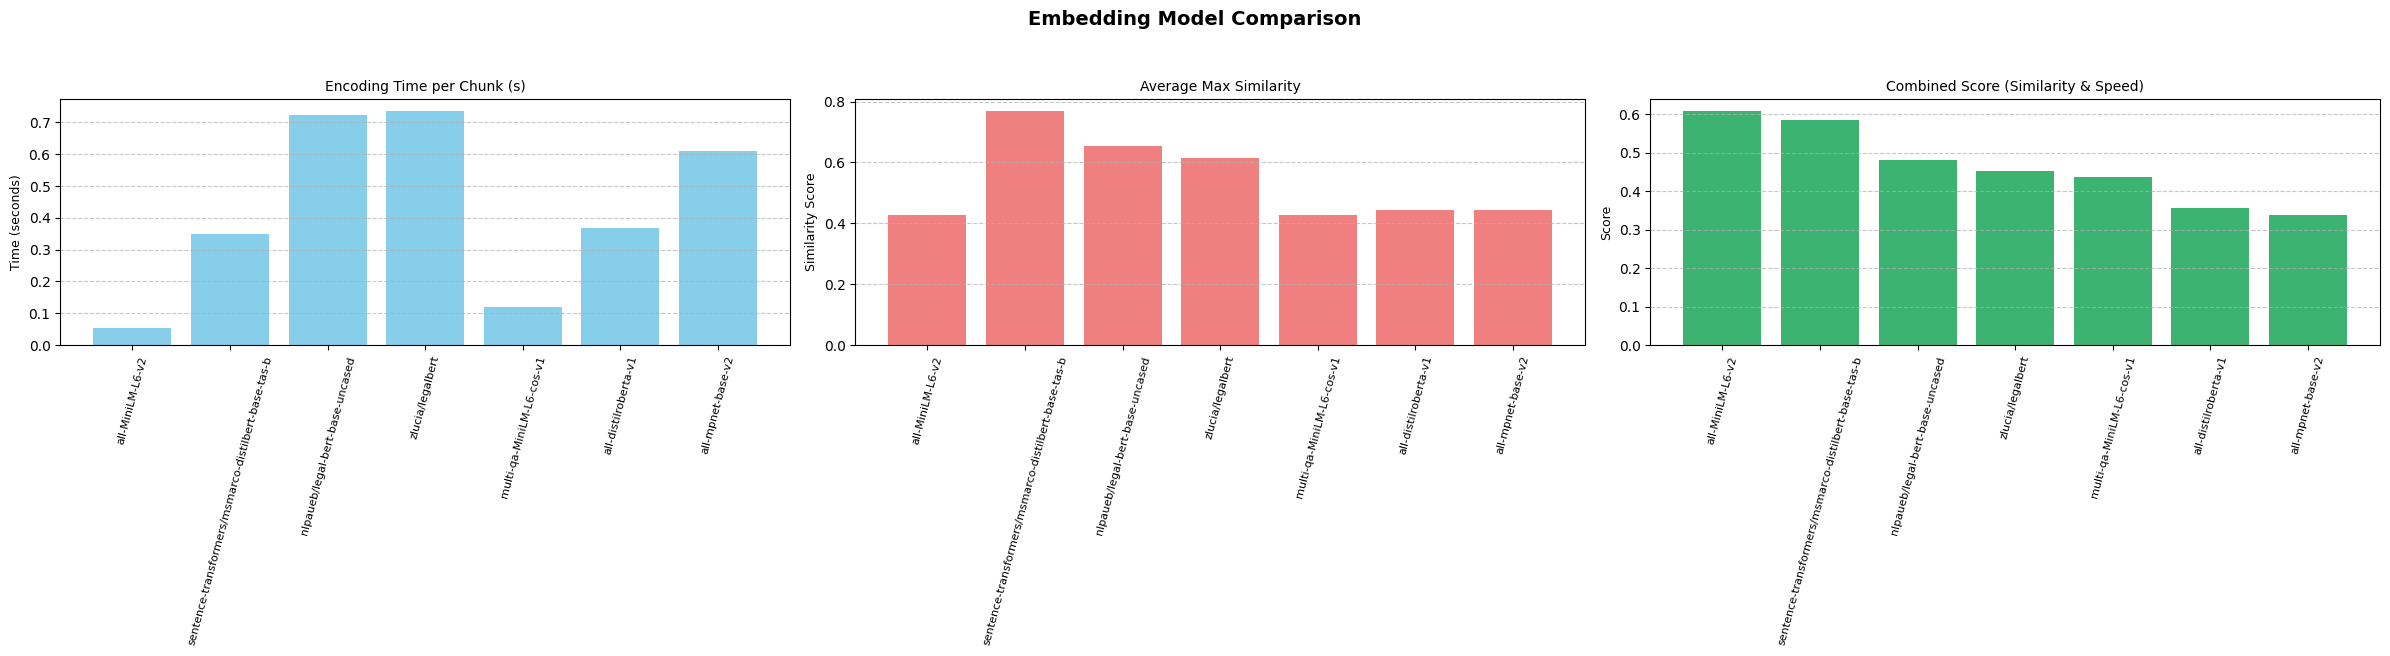

Proceeding with embedding generation for 6434 chunks.

Comparing 7 models using a sample of 500 chunks...
Pre-checking model encoding speeds...


Pre-checking models:  43%|████▎     | 3/7 [01:08<01:46, 26.56s/it]No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
Pre-checking models:  57%|█████▋    | 4/7 [02:26<02:20, 46.94s/it]No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
Pre-checking models: 100%|██████████| 7/7 [05:32<00:00, 47.47s/it]



Testing embedding models...


Testing embedding models:  43%|████▎     | 3/7 [01:07<01:44, 26.03s/it]No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
Testing embedding models:  57%|█████▋    | 4/7 [02:23<02:17, 45.86s/it]No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
Testing embedding models: 100%|██████████| 7/7 [05:29<00:00, 47.13s/it]


Model Comparison Results:


model_name  embedding_dim  \
0                                   all-MiniLM-L6-v2            384   
2  sentence-transformers/msmarco-distilbert-base-...            768   
3                    nlpaueb/legal-bert-base-uncased            768   
4                                   zlucia/legalbert            768   
1                          multi-qa-MiniLM-L6-cos-v1            384   
6                               all-distilroberta-v1            768   
5                                  all-mpnet-base-v2            768   

   load_time  encoding_time  avg_max_similarity  encoding_time_per_doc  \
0   4.603690       5.444025            0.428944               0.054440   
2   5.046333      34.825603            0.768942               0.348256   
3   3.171870      72.356311            0.653772               0.723563   
4   4.602424      73.570784            0.615028               0.735708   
1   4.085175      12.046566            0.427118               0.120466   
6   4.509183      36.695670            0.442404               0.366957   
5   4.039202      60.947440            0.444712               0.609474   

   combined_score  
0        0.608531  
2        0.586449  
3        0.480835  
4        0.453331  
1        0.438295  
6        0.355417  
5        0.338834

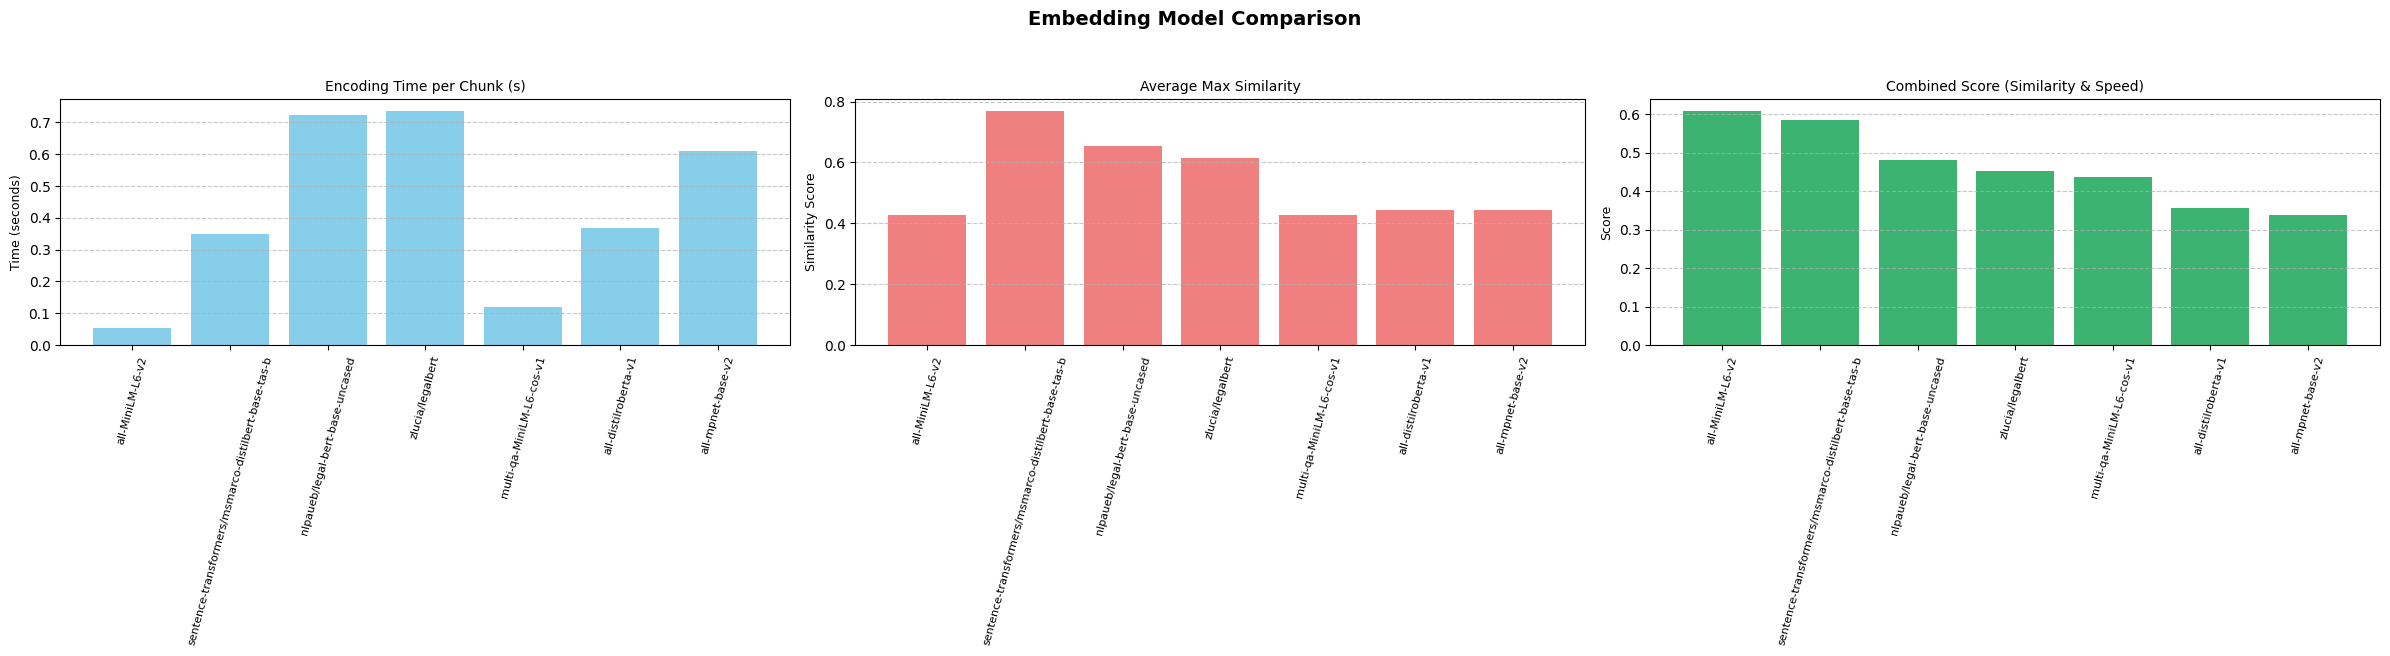


Selected best model: all-MiniLM-L6-v2 (Score: 0.6085)

Generating final embeddings for all 6434 chunks using all-MiniLM-L6-v2...
Loading model: all-MiniLM-L6-v2
CUDA not available. Using CPU batch size: 32
Generating embeddings...
CUDA not available. Using CPU batch size: 32
Generating embeddings...


Proceeding with embedding generation for 6434 chunks.

Comparing 7 models using a sample of 500 chunks...
Pre-checking model encoding speeds...


Pre-checking models:  43%|████▎     | 3/7 [01:08<01:46, 26.56s/it]No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
Pre-checking models:  57%|█████▋    | 4/7 [02:26<02:20, 46.94s/it]No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
Pre-checking models: 100%|██████████| 7/7 [05:32<00:00, 47.47s/it]



Testing embedding models...


Testing embedding models:  43%|████▎     | 3/7 [01:07<01:44, 26.03s/it]No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
Testing embedding models:  57%|█████▋    | 4/7 [02:23<02:17, 45.86s/it]No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
Testing embedding models: 100%|██████████| 7/7 [05:29<00:00, 47.13s/it]


Model Comparison Results:


model_name  embedding_dim  \
0                                   all-MiniLM-L6-v2            384   
2  sentence-transformers/msmarco-distilbert-base-...            768   
3                    nlpaueb/legal-bert-base-uncased            768   
4                                   zlucia/legalbert            768   
1                          multi-qa-MiniLM-L6-cos-v1            384   
6                               all-distilroberta-v1            768   
5                                  all-mpnet-base-v2            768   

   load_time  encoding_time  avg_max_similarity  encoding_time_per_doc  \
0   4.603690       5.444025            0.428944               0.054440   
2   5.046333      34.825603            0.768942               0.348256   
3   3.171870      72.356311            0.653772               0.723563   
4   4.602424      73.570784            0.615028               0.735708   
1   4.085175      12.046566            0.427118               0.120466   
6   4.509183      36.695670            0.442404               0.366957   
5   4.039202      60.947440            0.444712               0.609474   

   combined_score  
0        0.608531  
2        0.586449  
3        0.480835  
4        0.453331  
1        0.438295  
6        0.355417  
5        0.338834

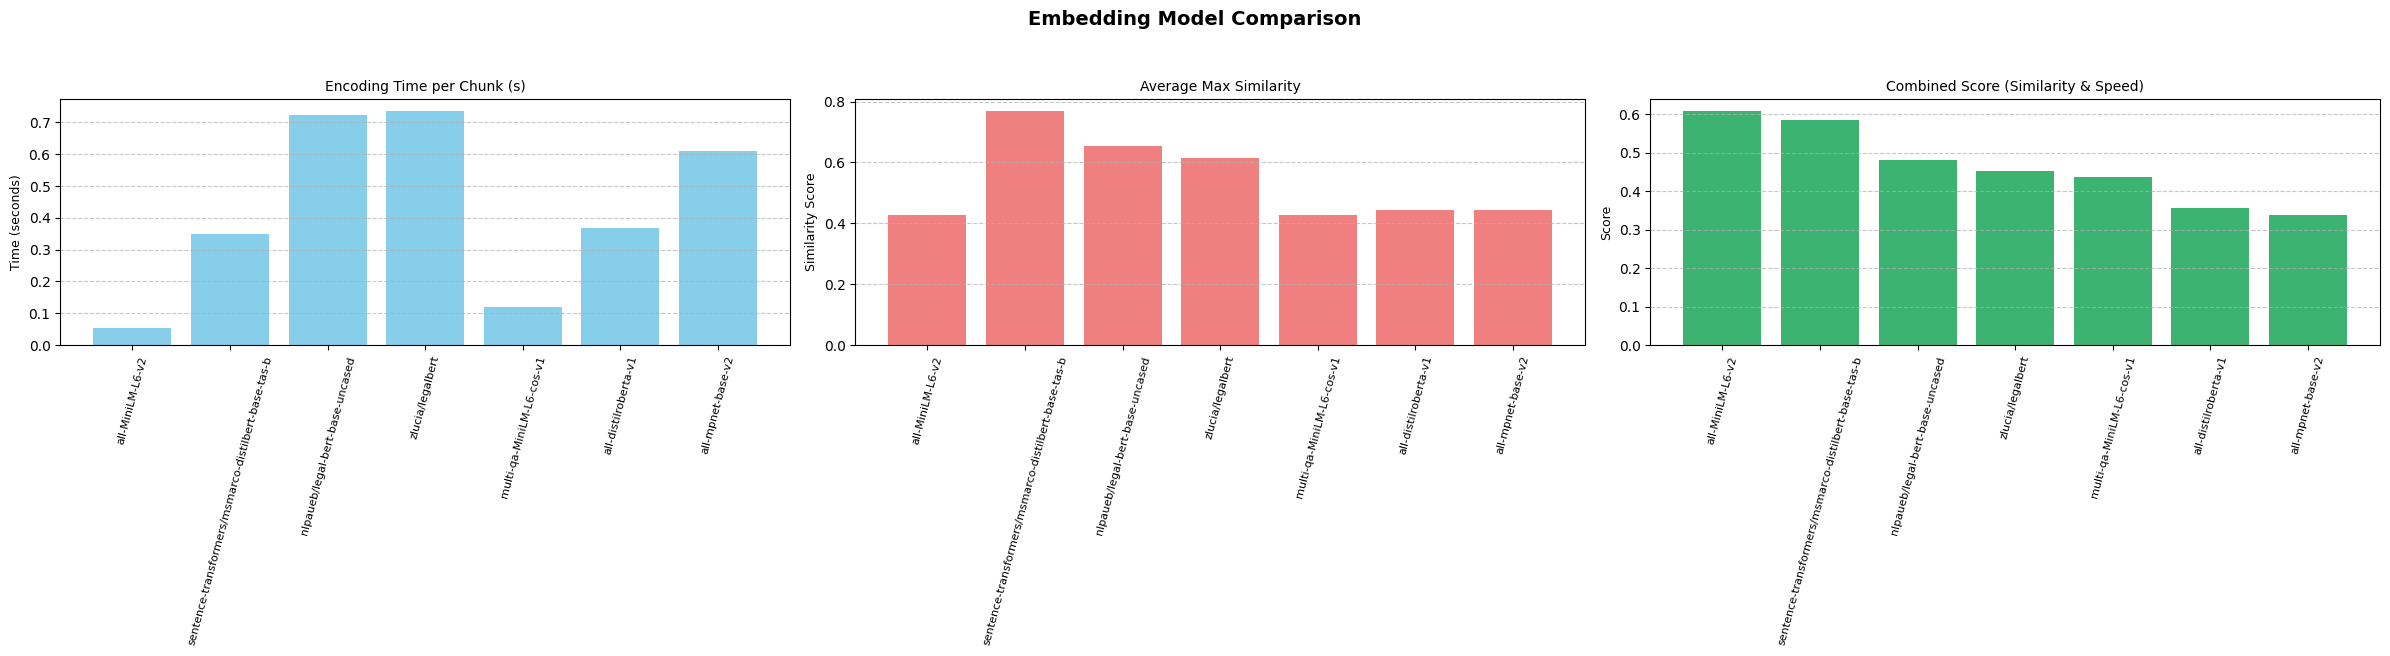


Selected best model: all-MiniLM-L6-v2 (Score: 0.6085)

Generating final embeddings for all 6434 chunks using all-MiniLM-L6-v2...
Loading model: all-MiniLM-L6-v2
CUDA not available. Using CPU batch size: 32
Generating embeddings...
CUDA not available. Using CPU batch size: 32
Generating embeddings...


Batch encoding: 100%|██████████| 202/202 [06:16<00:00,  1.86s/it]

Proceeding with embedding generation for 6434 chunks.

Comparing 7 models using a sample of 500 chunks...
Pre-checking model encoding speeds...


Pre-checking models:  43%|████▎     | 3/7 [01:08<01:46, 26.56s/it]No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
Pre-checking models:  57%|█████▋    | 4/7 [02:26<02:20, 46.94s/it]No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
Pre-checking models: 100%|██████████| 7/7 [05:32<00:00, 47.47s/it]



Testing embedding models...


Testing embedding models:  43%|████▎     | 3/7 [01:07<01:44, 26.03s/it]No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
Testing embedding models:  57%|█████▋    | 4/7 [02:23<02:17, 45.86s/it]No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
Testing embedding models: 100%|██████████| 7/7 [05:29<00:00, 47.13s/it]


Model Comparison Results:


model_name  embedding_dim  \
0                                   all-MiniLM-L6-v2            384   
2  sentence-transformers/msmarco-distilbert-base-...            768   
3                    nlpaueb/legal-bert-base-uncased            768   
4                                   zlucia/legalbert            768   
1                          multi-qa-MiniLM-L6-cos-v1            384   
6                               all-distilroberta-v1            768   
5                                  all-mpnet-base-v2            768   

   load_time  encoding_time  avg_max_similarity  encoding_time_per_doc  \
0   4.603690       5.444025            0.428944               0.054440   
2   5.046333      34.825603            0.768942               0.348256   
3   3.171870      72.356311            0.653772               0.723563   
4   4.602424      73.570784            0.615028               0.735708   
1   4.085175      12.046566            0.427118               0.120466   
6   4.509183      36.695670            0.442404               0.366957   
5   4.039202      60.947440            0.444712               0.609474   

   combined_score  
0        0.608531  
2        0.586449  
3        0.480835  
4        0.453331  
1        0.438295  
6        0.355417  
5        0.338834

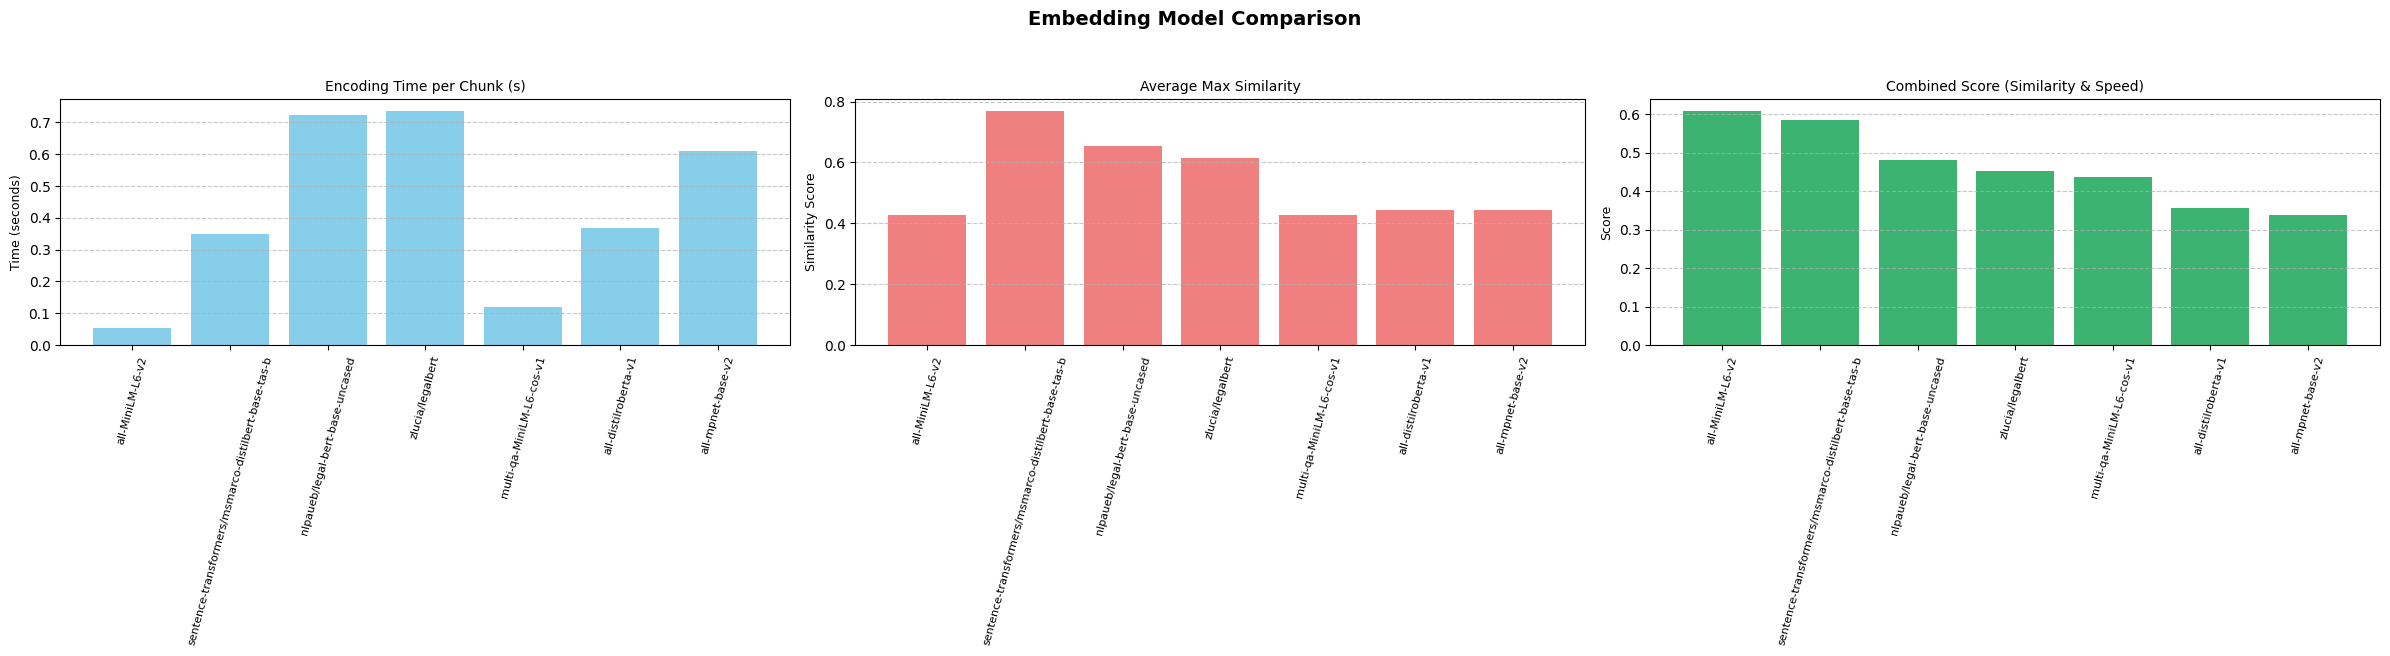


Selected best model: all-MiniLM-L6-v2 (Score: 0.6085)

Generating final embeddings for all 6434 chunks using all-MiniLM-L6-v2...
Loading model: all-MiniLM-L6-v2
CUDA not available. Using CPU batch size: 32
Generating embeddings...
CUDA not available. Using CPU batch size: 32
Generating embeddings...


Batch encoding: 100%|██████████| 202/202 [06:16<00:00,  1.86s/it]

Generated embeddings with shape: (6434, 384)

Finished generating embeddings. Shape of matrix: (6434, 384)
`hybrid_chunks_df` DataFrame now contains the 'embedding' column.
`full_embeddings_matrix` holds the numpy array of embeddings.
`final_model_object` is the loaded SentenceTransformer model.


Proceeding with embedding generation for 6434 chunks.

Comparing 7 models using a sample of 500 chunks...
Pre-checking model encoding speeds...


Pre-checking models:  43%|████▎     | 3/7 [01:08<01:46, 26.56s/it]No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
Pre-checking models:  57%|█████▋    | 4/7 [02:26<02:20, 46.94s/it]No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
Pre-checking models: 100%|██████████| 7/7 [05:32<00:00, 47.47s/it]



Testing embedding models...


Testing embedding models:  43%|████▎     | 3/7 [01:07<01:44, 26.03s/it]No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
Testing embedding models:  57%|█████▋    | 4/7 [02:23<02:17, 45.86s/it]No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
Testing embedding models: 100%|██████████| 7/7 [05:29<00:00, 47.13s/it]


Model Comparison Results:


model_name  embedding_dim  \
0                                   all-MiniLM-L6-v2            384   
2  sentence-transformers/msmarco-distilbert-base-...            768   
3                    nlpaueb/legal-bert-base-uncased            768   
4                                   zlucia/legalbert            768   
1                          multi-qa-MiniLM-L6-cos-v1            384   
6                               all-distilroberta-v1            768   
5                                  all-mpnet-base-v2            768   

   load_time  encoding_time  avg_max_similarity  encoding_time_per_doc  \
0   4.603690       5.444025            0.428944               0.054440   
2   5.046333      34.825603            0.768942               0.348256   
3   3.171870      72.356311            0.653772               0.723563   
4   4.602424      73.570784            0.615028               0.735708   
1   4.085175      12.046566            0.427118               0.120466   
6   4.509183      36.695670            0.442404               0.366957   
5   4.039202      60.947440            0.444712               0.609474   

   combined_score  
0        0.608531  
2        0.586449  
3        0.480835  
4        0.453331  
1        0.438295  
6        0.355417  
5        0.338834

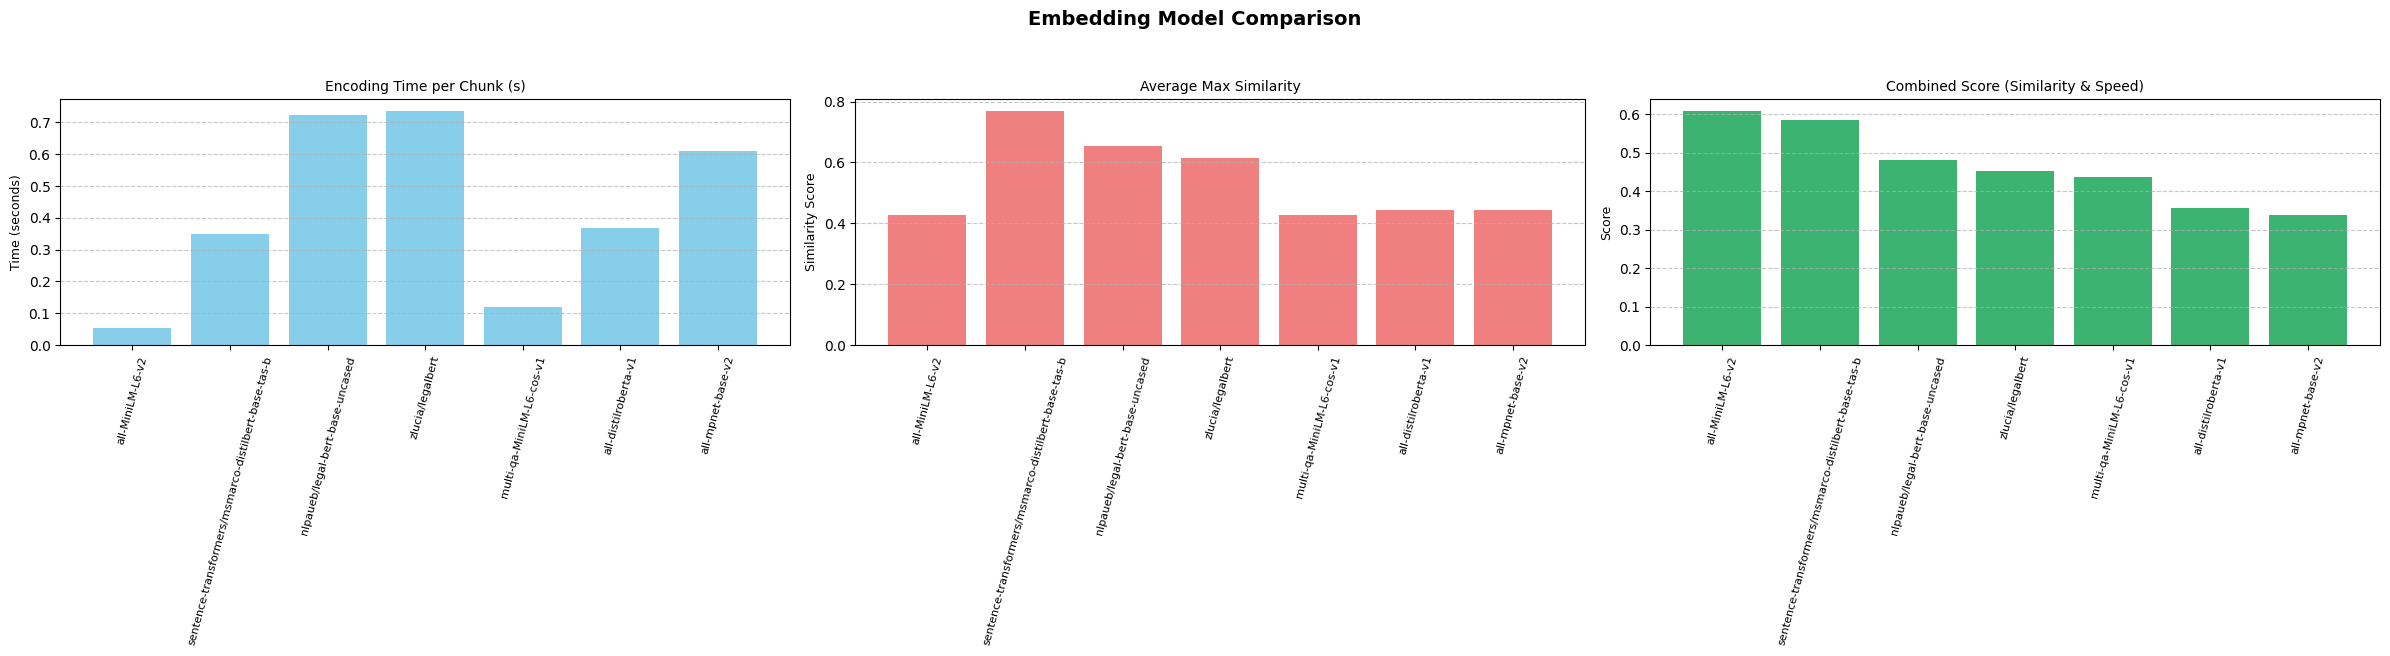


Selected best model: all-MiniLM-L6-v2 (Score: 0.6085)

Generating final embeddings for all 6434 chunks using all-MiniLM-L6-v2...
Loading model: all-MiniLM-L6-v2
CUDA not available. Using CPU batch size: 32
Generating embeddings...
CUDA not available. Using CPU batch size: 32
Generating embeddings...


Batch encoding: 100%|██████████| 202/202 [06:16<00:00,  1.86s/it]

Generated embeddings with shape: (6434, 384)

Finished generating embeddings. Shape of matrix: (6434, 384)
`hybrid_chunks_df` DataFrame now contains the 'embedding' column.
`full_embeddings_matrix` holds the numpy array of embeddings.
`final_model_object` is the loaded SentenceTransformer model.


In [19]:
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
import time
import gc
import torch
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# Global query embedding cache
query_embedding_cache = {}

def get_cached_query_embedding(query, model):
    global query_embedding_cache
    
    # Attempt to get a consistent model name for caching
    model_name_for_cache = getattr(model, 'name_or_path', None) # For HuggingFace models
    if model_name_for_cache is None:
        model_name_for_cache = getattr(model, 'model_name_or_path', str(model).split('(')[0]) # Fallback for SentenceTransformer
    
    cache_key = f"{model_name_for_cache}:{query}"
    
    if cache_key in query_embedding_cache:
        return query_embedding_cache[cache_key]
    
    try:
        query_embedding = model.encode([query], show_progress_bar=False)[0].astype(np.float32)
        # Normalize the embedding
        norm = np.linalg.norm(query_embedding)
        if norm == 0: # Avoid division by zero for zero vectors
            query_embedding_normalized = query_embedding
        else:
            query_embedding_normalized = query_embedding / norm
        
        query_embedding_cache[cache_key] = query_embedding_normalized
        
        # Limit cache size
        if len(query_embedding_cache) > 1000:
            oldest_query = next(iter(query_embedding_cache))
            query_embedding_cache.pop(oldest_query)
            
        return query_embedding_normalized
    except Exception as e:
        print(f"Error encoding query '{query}': {e}")
        # Return zero vector of appropriate dimension if model has get_sentence_embedding_dimension
        if hasattr(model, 'get_sentence_embedding_dimension'):
            return np.zeros(model.get_sentence_embedding_dimension(), dtype=np.float32)
        else: # Fallback if dimension cannot be determined (less ideal)
            return np.array([], dtype=np.float32) 

def compare_embedding_models(test_chunks_df, models_to_test_list):
    sample_docs_text = test_chunks_df.sample(min(5, len(test_chunks_df)))['text'].tolist()
    
    test_queries = []
    for doc_text_item in sample_docs_text:
        sentences = doc_text_item.split('.')
        if len(sentences) > 2:
            middle_sentence = sentences[len(sentences)//2].strip()
            if middle_sentence: test_queries.append(middle_sentence)
    
    if len(test_queries) < 3:
        fallback_queries = [
            "intellectual property rights of employees",
            "confidentiality obligations in agreements",
            "reporting workplace safety incidents"
        ]
        needed = 3 - len(test_queries)
        test_queries.extend(fallback_queries[:needed])
    
    sample_chunks_for_comparison = test_chunks_df.sample(min(100, len(test_chunks_df)))
    results = []
    all_normalized_speeds = []

    print("Pre-checking model encoding speeds...")
    for model_name in tqdm(models_to_test_list, desc="Pre-checking models"):
        try:
            model_temp = SentenceTransformer(model_name)
            chunk_texts_temp = sample_chunks_for_comparison['text'].tolist()
            start_time_temp = time.time()
            _ = model_temp.encode(chunk_texts_temp, show_progress_bar=False)
            encoding_time_temp = time.time() - start_time_temp
            normalized_speed_temp = 1.0 / (encoding_time_temp + 1e-9) # Add small epsilon
            all_normalized_speeds.append(normalized_speed_temp)
        except Exception as e:
            print(f"Error during pre-check for {model_name}: {e}")
            all_normalized_speeds.append(1e-9) # Assign very low speed
        finally:
            if 'model_temp' in locals(): del model_temp
            gc.collect()
            if torch.cuda.is_available(): torch.cuda.empty_cache()

    max_overall_normalized_speed = max(all_normalized_speeds) if all_normalized_speeds else 1.0
    if max_overall_normalized_speed == 0: max_overall_normalized_speed = 1.0 # Avoid division by zero

    print("\nTesting embedding models...")
    for model_name in tqdm(models_to_test_list, desc="Testing embedding models"):
        try:
            start_time = time.time()
            model = SentenceTransformer(model_name)
            load_time = time.time() - start_time
            
            chunk_texts_for_eval = sample_chunks_for_comparison['text'].tolist()
            start_time_encoding = time.time()
            chunk_embeddings = model.encode(chunk_texts_for_eval, show_progress_bar=False)
            encoding_time = time.time() - start_time_encoding
            
            query_embeddings = model.encode(test_queries, show_progress_bar=False)
            
            avg_similarity = 0.0
            if query_embeddings.shape[0] > 0 and chunk_embeddings.shape[0] > 0:
                for query_emb in query_embeddings:
                    sims = cosine_similarity(query_emb.reshape(1, -1), chunk_embeddings)[0]
                    avg_similarity += np.max(sims) if len(sims) > 0 else 0.0
                avg_similarity /= query_embeddings.shape[0]
            
            normalized_similarity = avg_similarity
            current_normalized_speed = 1.0 / (encoding_time + 1e-9)
            scaled_speed_score = current_normalized_speed / max_overall_normalized_speed
            
            combined_score = (0.7 * normalized_similarity) + (0.3 * scaled_speed_score)
            embedding_dim_val = model.get_sentence_embedding_dimension() if hasattr(model, 'get_sentence_embedding_dimension') else None
            if embedding_dim_val is None and chunk_embeddings.ndim > 1 : embedding_dim_val = chunk_embeddings.shape[1]

            results.append({
                'model_name': model_name, 'embedding_dim': embedding_dim_val,
                'load_time': load_time, 'encoding_time': encoding_time,
                'avg_max_similarity': avg_similarity,
                'encoding_time_per_doc': encoding_time / len(chunk_texts_for_eval) if len(chunk_texts_for_eval) > 0 else float('inf'),
                'combined_score': combined_score
            })
        except Exception as e:
            print(f"Error testing model {model_name}: {e}")
            results.append({
                'model_name': model_name, 'embedding_dim': None, 'load_time': None, 
                'encoding_time': None, 'avg_max_similarity': None, 
                'encoding_time_per_doc': None, 'combined_score': None, 'error': str(e)
            })
        finally:
            if 'model' in locals(): del model
            gc.collect()
            if torch.cuda.is_available(): torch.cuda.empty_cache()
                
    return pd.DataFrame(results)

def generate_optimized_embeddings(source_chunks_df, model_name_to_use):
    print(f"Loading model: {model_name_to_use}")
    model = SentenceTransformer(model_name_to_use)
    
    batch_size = 32
    if torch.cuda.is_available():
        try:
            free_mem_bytes = torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_allocated(0)
            free_mem_gb = free_mem_bytes / (1024**3)
            if free_mem_gb > 12: batch_size = 128
            elif free_mem_gb > 8: batch_size = 64
            elif free_mem_gb > 4: batch_size = 32
            else: batch_size = 16
            print(f"CUDA available ({free_mem_gb:.2f}GB free). Using batch size: {batch_size}")
        except Exception as e:
            print(f"Could not query CUDA memory, defaulting batch size to 32. Error: {e}")
            batch_size = 32
    else:
        print(f"CUDA not available. Using CPU batch size: {batch_size}")
    
    print("Generating embeddings...")
    texts_to_embed = source_chunks_df['text'].tolist()
    num_texts = len(texts_to_embed)
    embedding_dim = model.get_sentence_embedding_dimension()
    all_embeddings = np.zeros((num_texts, embedding_dim), dtype=np.float32)
    
    if num_texts > 0:
        for i in tqdm(range(0, num_texts, batch_size), desc="Batch encoding"):
            batch_texts = texts_to_embed[i:i+batch_size]
            batch_embeddings = model.encode(batch_texts, show_progress_bar=False, convert_to_numpy=True).astype(np.float32)
            all_embeddings[i:i+len(batch_texts)] = batch_embeddings
    
    output_chunks_df = source_chunks_df.copy() # Make a copy to avoid SettingWithCopyWarning
    output_chunks_df['embedding'] = list(all_embeddings)
    
    print(f"Generated embeddings with shape: {all_embeddings.shape}")
    return output_chunks_df, all_embeddings, model

# --- Main script execution for embedding generation ---

# Ensure `hybrid_chunks_df` is available from your previous chunking step.
if 'hybrid_chunks_df' in locals() and hybrid_chunks_df is not None and not hybrid_chunks_df.empty:
    print(f"Proceeding with embedding generation for {len(hybrid_chunks_df)} chunks.")
    
    models_to_test_list = [
        'all-MiniLM-L6-v2',           # Fast, good baseline
        'multi-qa-MiniLM-L6-cos-v1',  # Optimized for semantic search (QA)
        'sentence-transformers/msmarco-distilbert-base-tas-b', # TAS-B for dense retrieval
        'nlpaueb/legal-bert-base-uncased', # Legal-specific BERT
        'zlucia/legalbert',                # Another legal-specific BERT, often performs well
        'all-mpnet-base-v2',           # High quality, but slower
        'all-distilroberta-v1',        # Good balance
    ]
    
    sample_size_for_comparison = min(500, len(hybrid_chunks_df))
    test_chunks_for_model_comparison = hybrid_chunks_df.sample(sample_size_for_comparison, random_state=42)
    
    print(f"\nComparing {len(models_to_test_list)} models using a sample of {len(test_chunks_for_model_comparison)} chunks...")
    model_comparison_df = compare_embedding_models(test_chunks_for_model_comparison, models_to_test_list)
    
    print("\nModel Comparison Results:")
    try:
        display(model_comparison_df.sort_values(by='combined_score', ascending=False))
    except NameError: # Fallback if not in Jupyter
        print(model_comparison_df.sort_values(by='combined_score', ascending=False).to_string())

    if not model_comparison_df.empty and 'model_name' in model_comparison_df.columns:
        plot_df = model_comparison_df.dropna(subset=['encoding_time_per_doc', 'avg_max_similarity', 'combined_score']).copy()
        if not plot_df.empty:
            plot_df.sort_values(by='combined_score', ascending=False, inplace=True)
            fig, ax = plt.subplots(1, 3, figsize=(24, 7))
            
            ax[0].bar(plot_df['model_name'], plot_df['encoding_time_per_doc'], color='skyblue')
            ax[0].set_title('Encoding Time per Chunk (s)', fontsize=10)
            ax[0].set_ylabel('Time (seconds)', fontsize=9)
            ax[0].tick_params(axis='x', rotation=75, labelsize=8)
            ax[0].grid(axis='y', linestyle='--', alpha=0.7)

            ax[1].bar(plot_df['model_name'], plot_df['avg_max_similarity'], color='lightcoral')
            ax[1].set_title('Average Max Similarity', fontsize=10)
            ax[1].set_ylabel('Similarity Score', fontsize=9)
            ax[1].tick_params(axis='x', rotation=75, labelsize=8)
            ax[1].grid(axis='y', linestyle='--', alpha=0.7)

            ax[2].bar(plot_df['model_name'], plot_df['combined_score'], color='mediumseagreen')
            ax[2].set_title('Combined Score (Similarity & Speed)', fontsize=10)
            ax[2].set_ylabel('Score', fontsize=9)
            ax[2].tick_params(axis='x', rotation=75, labelsize=8)
            ax[2].grid(axis='y', linestyle='--', alpha=0.7)
            
            plt.suptitle('Embedding Model Comparison', fontsize=14, fontweight='bold')
            plt.tight_layout(rect=[0, 0.05, 1, 0.95])
            plt.show()
        else:
            print("No valid model data to plot after filtering errors.")
            
        if 'combined_score' in model_comparison_df.columns and not model_comparison_df['combined_score'].isnull().all():
            best_model_row = model_comparison_df.loc[model_comparison_df['combined_score'].idxmax()]
            selected_model_name = best_model_row['model_name']
            print(f"\nSelected best model: {selected_model_name} (Score: {best_model_row['combined_score']:.4f})")
            
            print(f"\nGenerating final embeddings for all {len(hybrid_chunks_df)} chunks using {selected_model_name}...")
            # The generate_optimized_embeddings function returns the df with embeddings, the matrix, and the model
            hybrid_chunks_df, full_embeddings_matrix, final_model_object = generate_optimized_embeddings(hybrid_chunks_df, selected_model_name)
            
            print(f"\nFinished generating embeddings. Shape of matrix: {full_embeddings_matrix.shape}")
            print("`hybrid_chunks_df` DataFrame now contains the 'embedding' column.")
            print("`full_embeddings_matrix` holds the numpy array of embeddings.")
            print("`final_model_object` is the loaded SentenceTransformer model.")
            
            # Optional: Save the DataFrame with embeddings
# hybrid_chunks_df.to_pickle("hybrid_chunks_with_embeddings.pkl")
# print("Saved hybrid_chunks_df to hybrid_chunks_with_embeddings.pkl")
        else:
            print("\nCould not select the best model. Check comparison results for errors or all NaN scores.")
    else:
        print("\nModel comparison DataFrame is empty or malformed. Skipping plotting and final embedding generation.")
else:
    print("hybrid_chunks_df is not defined or is empty. Please ensure the chunking step has run successfully and `hybrid_chunks_df` is populated.")

In [20]:
# Save hybrid_chunks_df (Pandas DataFrame with embeddings)
print("Attempting to save hybrid_chunks_df...")
try:
    if 'hybrid_chunks_df' in locals() or 'hybrid_chunks_df' in globals():
        hybrid_chunks_df.to_pickle('c:/Repositories/USA_Project/Graph-Test/hybrid_chunks_with_embeddings.pkl')
        print("DataFrame 'hybrid_chunks_df' saved to 'c:/Repositories/USA_Project/Graph-Test/hybrid_chunks_with_embeddings.pkl'")
    else:
        print("Error: 'hybrid_chunks_df' not defined. Please ensure the previous cells that create this DataFrame have been run successfully.")
except Exception as e:
    print(f"An error occurred while saving hybrid_chunks_df: {e}")

Attempting to save hybrid_chunks_df...
DataFrame 'hybrid_chunks_df' saved to 'c:/Repositories/USA_Project/Graph-Test/hybrid_chunks_with_embeddings.pkl'


In [21]:
# Save full_embeddings_matrix (NumPy array)
import numpy as np
print("Attempting to save full_embeddings_matrix...")
try:
    if 'full_embeddings_matrix' in locals() or 'full_embeddings_matrix' in globals():
        np.save('c:/Repositories/USA_Project/Graph-Test/full_embeddings_matrix.npy', full_embeddings_matrix)
        print("NumPy array 'full_embeddings_matrix' saved to 'c:/Repositories/USA_Project/Graph-Test/full_embeddings_matrix.npy'")
    else:
        print("Error: 'full_embeddings_matrix' not defined. Please ensure the previous cells that create this NumPy array have been run successfully.")
except Exception as e:
    print(f"An error occurred while saving full_embeddings_matrix: {e}")

Attempting to save full_embeddings_matrix...
NumPy array 'full_embeddings_matrix' saved to 'c:/Repositories/USA_Project/Graph-Test/full_embeddings_matrix.npy'


## 5. Graph Construction

In [1]:
import pandas as pd
import numpy as np

# Load the processed data
try:
    hybrid_chunks_df = pd.read_pickle('c:/Repositories/USA_Project/Graph-Test/hybrid_chunks_with_embeddings.pkl')
    full_embeddings_matrix = np.load('c:/Repositories/USA_Project/Graph-Test/full_embeddings_matrix.npy', allow_pickle=True) # allow_pickle=True if embeddings are objects
    print("Successfully loaded hybrid_chunks_df and full_embeddings_matrix.")
    print(f"hybrid_chunks_df shape: {hybrid_chunks_df.shape}")
    print(f"full_embeddings_matrix shape: {full_embeddings_matrix.shape}")
    display(hybrid_chunks_df.head())
except FileNotFoundError as e:
    print(f"Error loading files: {e}. Please ensure the .pkl and .npy files are in the correct path.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Successfully loaded hybrid_chunks_df and full_embeddings_matrix.
hybrid_chunks_df shape: (6434, 18)
full_embeddings_matrix shape: (6434, 384)


chunk_id  doc_id                                           doc_name  \
0         0       0  AlliedEsportsEntertainmentInc_20190815_8-K_EX-...   
1         1       0  AlliedEsportsEntertainmentInc_20190815_8-K_EX-...   
2         2       0  AlliedEsportsEntertainmentInc_20190815_8-K_EX-...   
3         3       0  AlliedEsportsEntertainmentInc_20190815_8-K_EX-...   
4         4       0  AlliedEsportsEntertainmentInc_20190815_8-K_EX-...   

             category                                               text  \
0  License_Agreements  ExhibitJOINT CONTENT LICENSE AGREEMENT This JO...   
1  License_Agreements  respect to the United States are granted to, h...   
2  License_Agreements  animated, artistic, dramatic, sculptural, musi...   
3  License_Agreements  specifically described on Exhibit A, for the T...   
4  License_Agreements  to Licensee and rights of approval of Licensor...   

  chunk_method level  start_idx  end_idx document_position  position_score  \
0     semantic    L1          0     2782         beginning            0.95   
1     semantic    L1       2783     5586         beginning            0.85   
2     semantic    L1       5587     8324         beginning            0.85   
3     semantic    L1       8325    10884         beginning            0.85   
4     semantic    L1      10885    13437         beginning            0.85   

  is_special_section section_type  level_size contained_chunks  \
0               True  definitions         NaN              NaN   
1               True  definitions         NaN              NaN   
2               True  definitions         NaN              NaN   
3               True  definitions         NaN              NaN   
4               True  definitions         NaN              NaN   

                                 chunk_relationships  num_words  \
0  {'same_doc_l1_chunks': [1, 2, 3, 4, 5, 6, 7, 8...        400   
1  {'same_doc_l1_chunks': [0, 2, 3, 4, 5, 6, 7, 8...        400   
2  {'same_doc_l1_chunks': [0, 1, 3, 4, 5, 6, 7, 8...        400   
3  {'same_doc_l1_chunks': [0, 1, 2, 4, 5, 6, 7, 8...        400   
4  {'same_doc_l1_chunks': [0, 1, 2, 3, 5, 6, 7, 8...        400   

                                           embedding  
0  [-0.068951845, 0.059758257, -0.01722833, -0.10...  
1  [-0.0152194295, 0.024919977, -0.015922736, -0....  
2  [-0.06632526, 0.0420954, -0.027192306, -0.0674...  
3  [-0.08984932, -0.02100028, 0.047170132, -0.090...  
4  [-0.07408712, 0.009022912, -0.026969403, -0.07...

### 5.1. Define Nodes and Edges

Our graph will consist of nodes representing the chunks from `hybrid_chunks_df`. Each node will have attributes like `chunk_id`, `doc_id`, `text`, `level`, `category`, and its embedding.

Edges will be defined based on several criteria:
1.  **Hierarchical Relationships:** Based on the `contained_chunks` and `hierarchical_parents` columns in `hybrid_chunks_df`. For example, an L2 chunk node will have edges to the L1 chunk nodes it contains.
2.  **Same Document Relationships:** L1 chunks from the same document can be connected, as indicated in `same_doc_l1_chunks`.
3.  **Semantic Similarity:** We can compute cosine similarity between chunk embeddings. If the similarity between two chunk embeddings exceeds a certain threshold, an edge can be created between them. This helps connect semantically related chunks even if they are from different documents or different parts of the same document.
4.  **Special Section Connections:** We can add specific edges for `is_special_section` chunks, perhaps connecting all 'definitions' chunks or linking them to their parent document node more explicitly.

In [10]:
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity

# Initialize a new graph
G = nx.Graph()

# Add nodes with attributes from hybrid_chunks_df
if 'hybrid_chunks_df' in locals():
    for idx, row in hybrid_chunks_df.iterrows():
        G.add_node(
            row['chunk_id'], 
            doc_id=row['doc_id'], 
            doc_name=row['doc_name'],
            category=row['category'],
            text=row['text'][:100] + '...' if len(row['text']) > 100 else row['text'],  # Store a snippet
            level=row['level'],
            chunk_method=row['chunk_method'],
            start_idx=row['start_idx'],
            end_idx=row['end_idx'],
            is_special_section=row.get('is_special_section', False),
            section_type=row.get('section_type', None),
            embedding=row['embedding'] # Keep the embedding with the node
        )
    print(f"Added {G.number_of_nodes()} nodes to the graph.")

    # Add hierarchical and same-document edges
    edge_count = 0
    for idx, row in hybrid_chunks_df.iterrows():
        current_chunk_id = row['chunk_id']
        relationships = row.get('chunk_relationships', {})
        
        # Hierarchical parent edges (L1 to L2/L3/full)
        if relationships.get('hierarchical_parents'):
            for parent_id in relationships['hierarchical_parents']:
                if G.has_node(parent_id) and G.has_node(current_chunk_id):
                    G.add_edge(current_chunk_id, parent_id, type='hierarchical_child_to_parent')
                    edge_count += 1
        
        # Contained chunk edges (L2/L3/full to L1) - reverse of above, or use 'contained_chunks' from parent
        if row.get('contained_chunks') and isinstance(row['contained_chunks'], list):
            for child_id in row['contained_chunks']:
                if G.has_node(child_id) and G.has_node(current_chunk_id):
                    G.add_edge(current_chunk_id, child_id, type='hierarchical_parent_to_child')
                    edge_count += 1
                    
        # Same document L1 chunk edges
        if relationships.get('same_doc_l1_chunks'):
            for same_doc_l1_id in relationships['same_doc_l1_chunks']:
                if G.has_node(same_doc_l1_id) and G.has_node(current_chunk_id):
                    # Avoid duplicate edges in an undirected graph
                    if not G.has_edge(current_chunk_id, same_doc_l1_id):
                        G.add_edge(current_chunk_id, same_doc_l1_id, type='same_document_l1')
                        edge_count += 1
                        
    print(f"Added {edge_count} edges from hierarchical and same-document relationships.")

    # Add semantic similarity edges (example for a subset of L1 chunks to manage computation)
    l1_chunks = hybrid_chunks_df[hybrid_chunks_df['level'] == 'L1']
    # For demonstration, let's take a small sample or chunks from a specific document
    sample_l1_chunks = l1_chunks.sample(min(100, len(l1_chunks)), random_state=42) # Sample 100 L1 chunks or fewer

    similarity_threshold = 0.6 # Adjust as needed
    semantic_edge_count = 0

    if not sample_l1_chunks.empty and 'embedding' in sample_l1_chunks.columns:
        embeddings_sample = np.array(sample_l1_chunks['embedding'].tolist())
        if embeddings_sample.ndim == 2: # Ensure embeddings are correctly stacked
            cosine_sim_matrix = cosine_similarity(embeddings_sample)
            
            for i in range(len(sample_l1_chunks)):
                for j in range(i + 1, len(sample_l1_chunks)): # Avoid self-loops and duplicate edges
                    if cosine_sim_matrix[i, j] > similarity_threshold:
                        node1_id = sample_l1_chunks.iloc[i]['chunk_id']
                        node2_id = sample_l1_chunks.iloc[j]['chunk_id']
                        if G.has_node(node1_id) and G.has_node(node2_id):
                             if not G.has_edge(node1_id, node2_id): # Check if edge already exists
                                G.add_edge(node1_id, node2_id, type='semantic_similarity', weight=cosine_sim_matrix[i, j])
                                semantic_edge_count += 1
            print(f"Added {semantic_edge_count} semantic similarity edges (based on a sample of L1 chunks).")
        else:
            print("Embeddings for sample L1 chunks are not in the expected 2D array format.")
    else:
        print("No L1 chunks or embeddings found in the sample to calculate semantic similarity.")

    print(f"Total nodes in graph: {G.number_of_nodes()}")
    print(f"Total edges in graph: {G.number_of_edges()}")

    # Display a small part of the graph (e.g., nodes and edges related to one document)
    if not hybrid_chunks_df.empty:
        sample_doc_id = hybrid_chunks_df['doc_id'].unique()[0] # Take the first document ID
        nodes_of_sample_doc = [node for node, data in G.nodes(data=True) if data.get('doc_id') == sample_doc_id]
        
        if nodes_of_sample_doc:
            subgraph_sample_doc = G.subgraph(nodes_of_sample_doc)
            print(f"Subgraph for document ID {sample_doc_id} has {subgraph_sample_doc.number_of_nodes()} nodes and {subgraph_sample_doc.number_of_edges()} edges.")
            # For a very simple text representation:
            # for edge in list(subgraph_sample_doc.edges(data=True))[:5]: # Print first 5 edges of the subgraph
            #    print(edge)
        else:
            print(f"No nodes found for sample document ID {sample_doc_id}.")
else:
    print("hybrid_chunks_df is not defined. Cannot build graph.")

Added 6434 nodes to the graph.
Added 55317 edges from hierarchical and same-document relationships.
Added 51 semantic similarity edges (based on a sample of L1 chunks).
Total nodes in graph: 6434
Total edges in graph: 46842
Subgraph for document ID 0 has 36 nodes and 139 edges.
Added 55317 edges from hierarchical and same-document relationships.
Added 51 semantic similarity edges (based on a sample of L1 chunks).
Total nodes in graph: 6434
Total edges in graph: 46842
Subgraph for document ID 0 has 36 nodes and 139 edges.


Visualizing subgraph for document ID 100 with 37 nodes and 140 edges.


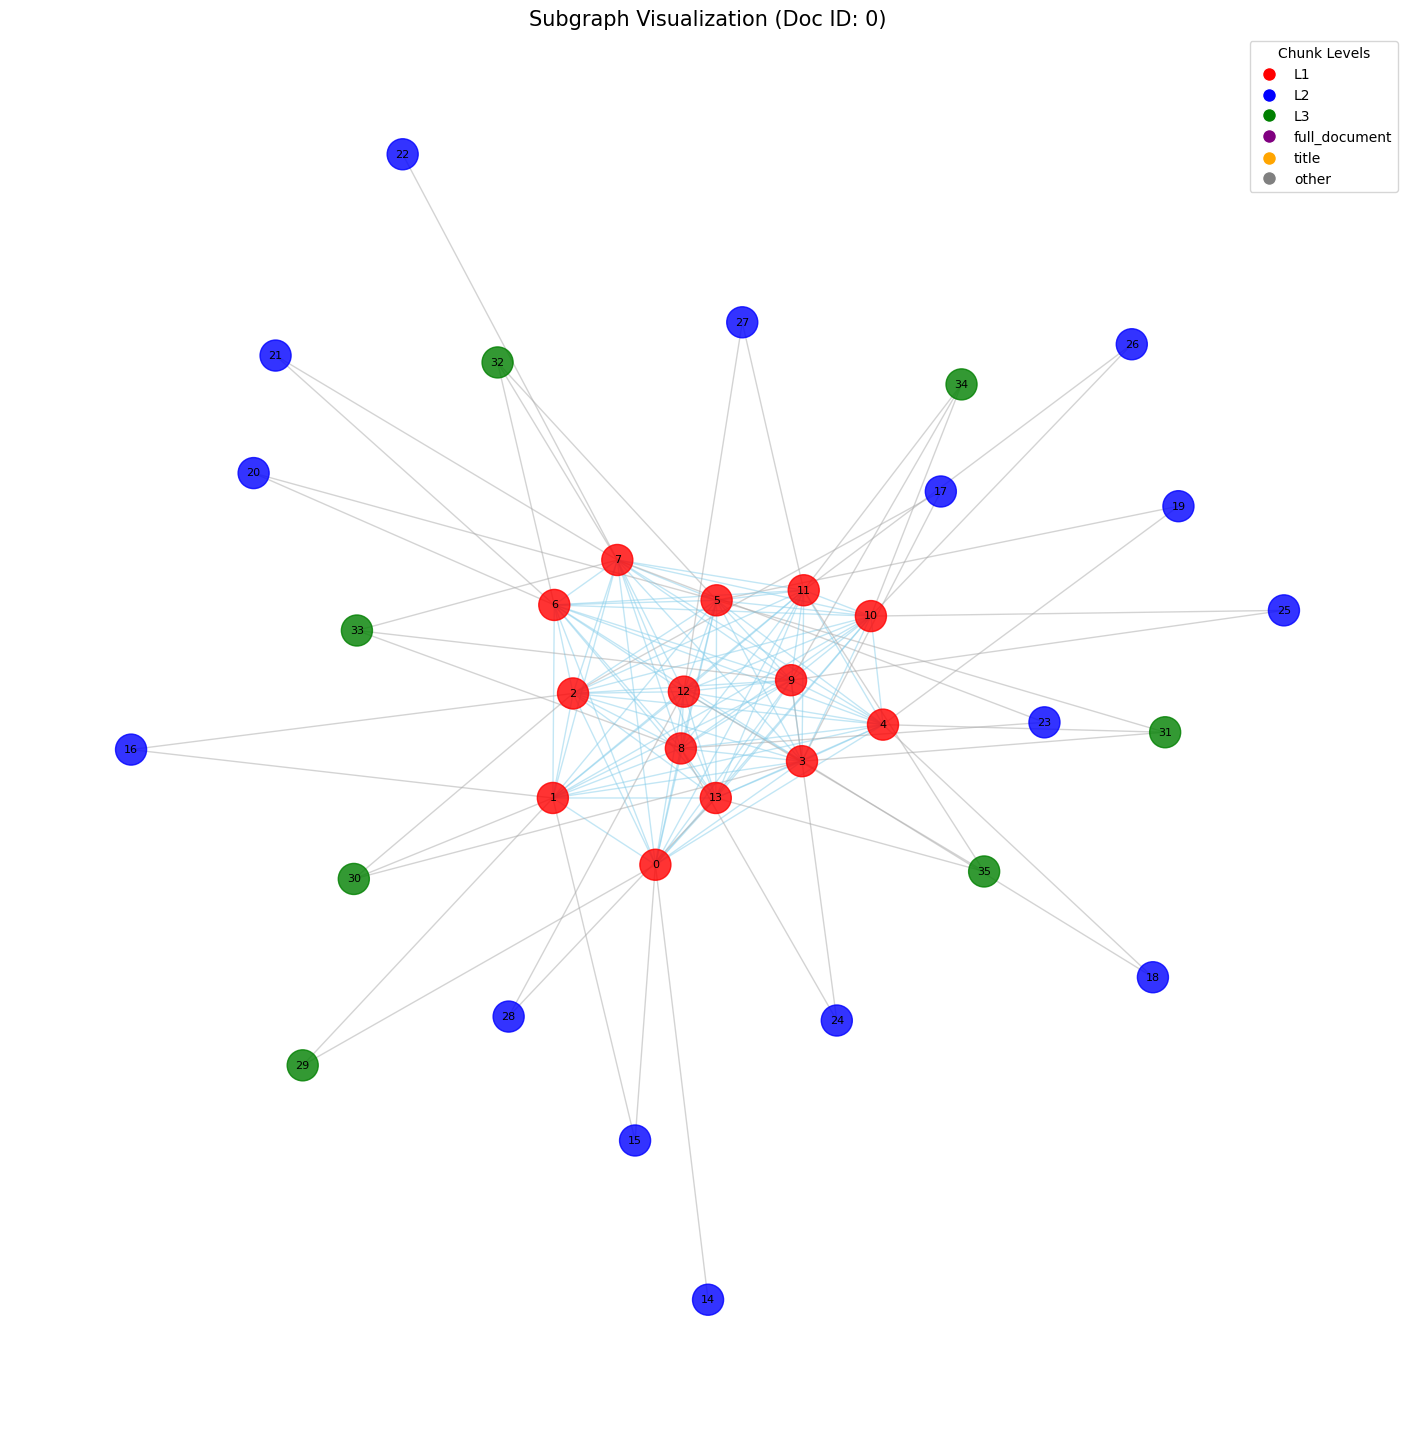

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np # ensure numpy is imported if not already

# Assuming G and subgraph_sample_doc are already defined from the previous cell.
# If subgraph_sample_doc is not defined, you might need to recreate it:
if 'G' in locals() and not hybrid_chunks_df.empty:
    sample_doc_id_to_viz = hybrid_chunks_df['doc_id'].unique()[0] 
    nodes_of_sample_doc_to_viz = [node for node, data in G.nodes(data=True) if data.get('doc_id') == sample_doc_id_to_viz]
    if nodes_of_sample_doc_to_viz:
        subgraph_to_visualize = G.subgraph(nodes_of_sample_doc_to_viz)
        print(f"Visualizing subgraph for document ID {sample_doc_id_to_viz} with {subgraph_to_visualize.number_of_nodes()} nodes and {subgraph_to_visualize.number_of_edges()} edges.")
    else:
        print(f"No nodes found for sample document ID {sample_doc_id_to_viz} to visualize.")
        subgraph_to_visualize = None
else:
    print("Graph G or hybrid_chunks_df not found. Cannot create subgraph for visualization.")
    subgraph_to_visualize = None

# Use subgraph_sample_doc if it exists from the previous cell's execution
if 'subgraph_sample_doc' in locals() and subgraph_sample_doc is not None and subgraph_sample_doc.number_of_nodes() > 0:
    plt.figure(figsize=(18, 18)) # Adjust figure size as needed
    
    # Position nodes using a layout algorithm
    # Spring layout is often good for general purpose, but others exist (e.g., kamada_kawai_layout, circular_layout)
    pos = nx.spring_layout(subgraph_sample_doc, k=0.5, iterations=50, seed=42) 

    # Get node attributes for coloring and labeling
    node_colors = []
    node_labels = {}
    levels = {'L1': 'red', 'L2': 'blue', 'L3': 'green', 'full_document': 'purple', 'title': 'orange', 'other': 'grey'}
    
    for node, data in subgraph_sample_doc.nodes(data=True):
        level = data.get('level', 'other')
        node_colors.append(levels.get(level, 'grey'))
        # Create a shorter label, e.g., chunk_id or part of it
        node_labels[node] = str(node)[:15] # Display first 15 chars of chunk_id

    # Draw nodes
    nx.draw_networkx_nodes(subgraph_sample_doc, pos, node_size=500, node_color=node_colors, alpha=0.8)
    
    # Draw edges
    edge_types = nx.get_edge_attributes(subgraph_sample_doc, 'type')
    edge_colors = {'hierarchical_child_to_parent': 'gray', 
                   'hierarchical_parent_to_child': 'darkgray', 
                   'same_document_l1': 'skyblue', 
                   'semantic_similarity': 'lightcoral'}
    
    default_edge_color = 'lightgrey'
    colors_for_edges = [edge_colors.get(edge_types.get(edge), default_edge_color) for edge in subgraph_sample_doc.edges()]

    nx.draw_networkx_edges(subgraph_sample_doc, pos, width=1.0, alpha=0.5, edge_color=colors_for_edges)
    
    # Draw labels
    nx.draw_networkx_labels(subgraph_sample_doc, pos, labels=node_labels, font_size=8)
    
    # Create a legend for node colors
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=level, 
                                 markersize=10, markerfacecolor=color) for level, color in levels.items()]
    plt.legend(handles=legend_handles, title="Chunk Levels", loc='best')

    plt.title(f"Subgraph Visualization (Doc ID: {subgraph_sample_doc.nodes(data=True)[list(subgraph_sample_doc.nodes())[0]].get('doc_id', 'Unknown')})", fontsize=15)
    plt.axis('off') # Turn off the axis
    plt.show()
    
elif 'G' in locals() and G.number_of_nodes() > 0:
    print("subgraph_sample_doc was not properly created or is empty. ")
    print("Consider visualizing a smaller, specific part of the main graph G if needed,")
    print("as visualizing the full graph is computationally intensive and likely unreadable.")
    print(f"Full graph G has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
else:
    print("Graph 'G' or 'subgraph_sample_doc' not found or is empty. Please ensure the graph construction cell has been run successfully.")


### Visualize Subgraph for Multiple Specified Documents
This allows us to see if and how selected documents are interconnected through shared L1 chunks (via semantic similarity if calculated for them) or other potential cross-document links if they were to be added.

Subgraph created with 519 nodes and 3972 edges.


C:\Users\Thevindu Kalubowila\AppData\Local\Temp\ipykernel_19480\2739152110.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  doc_id_color_map = {doc_id: plt.cm.get_cmap('viridis')(i/len(doc_ids)) for i, doc_id in enumerate(doc_ids)}


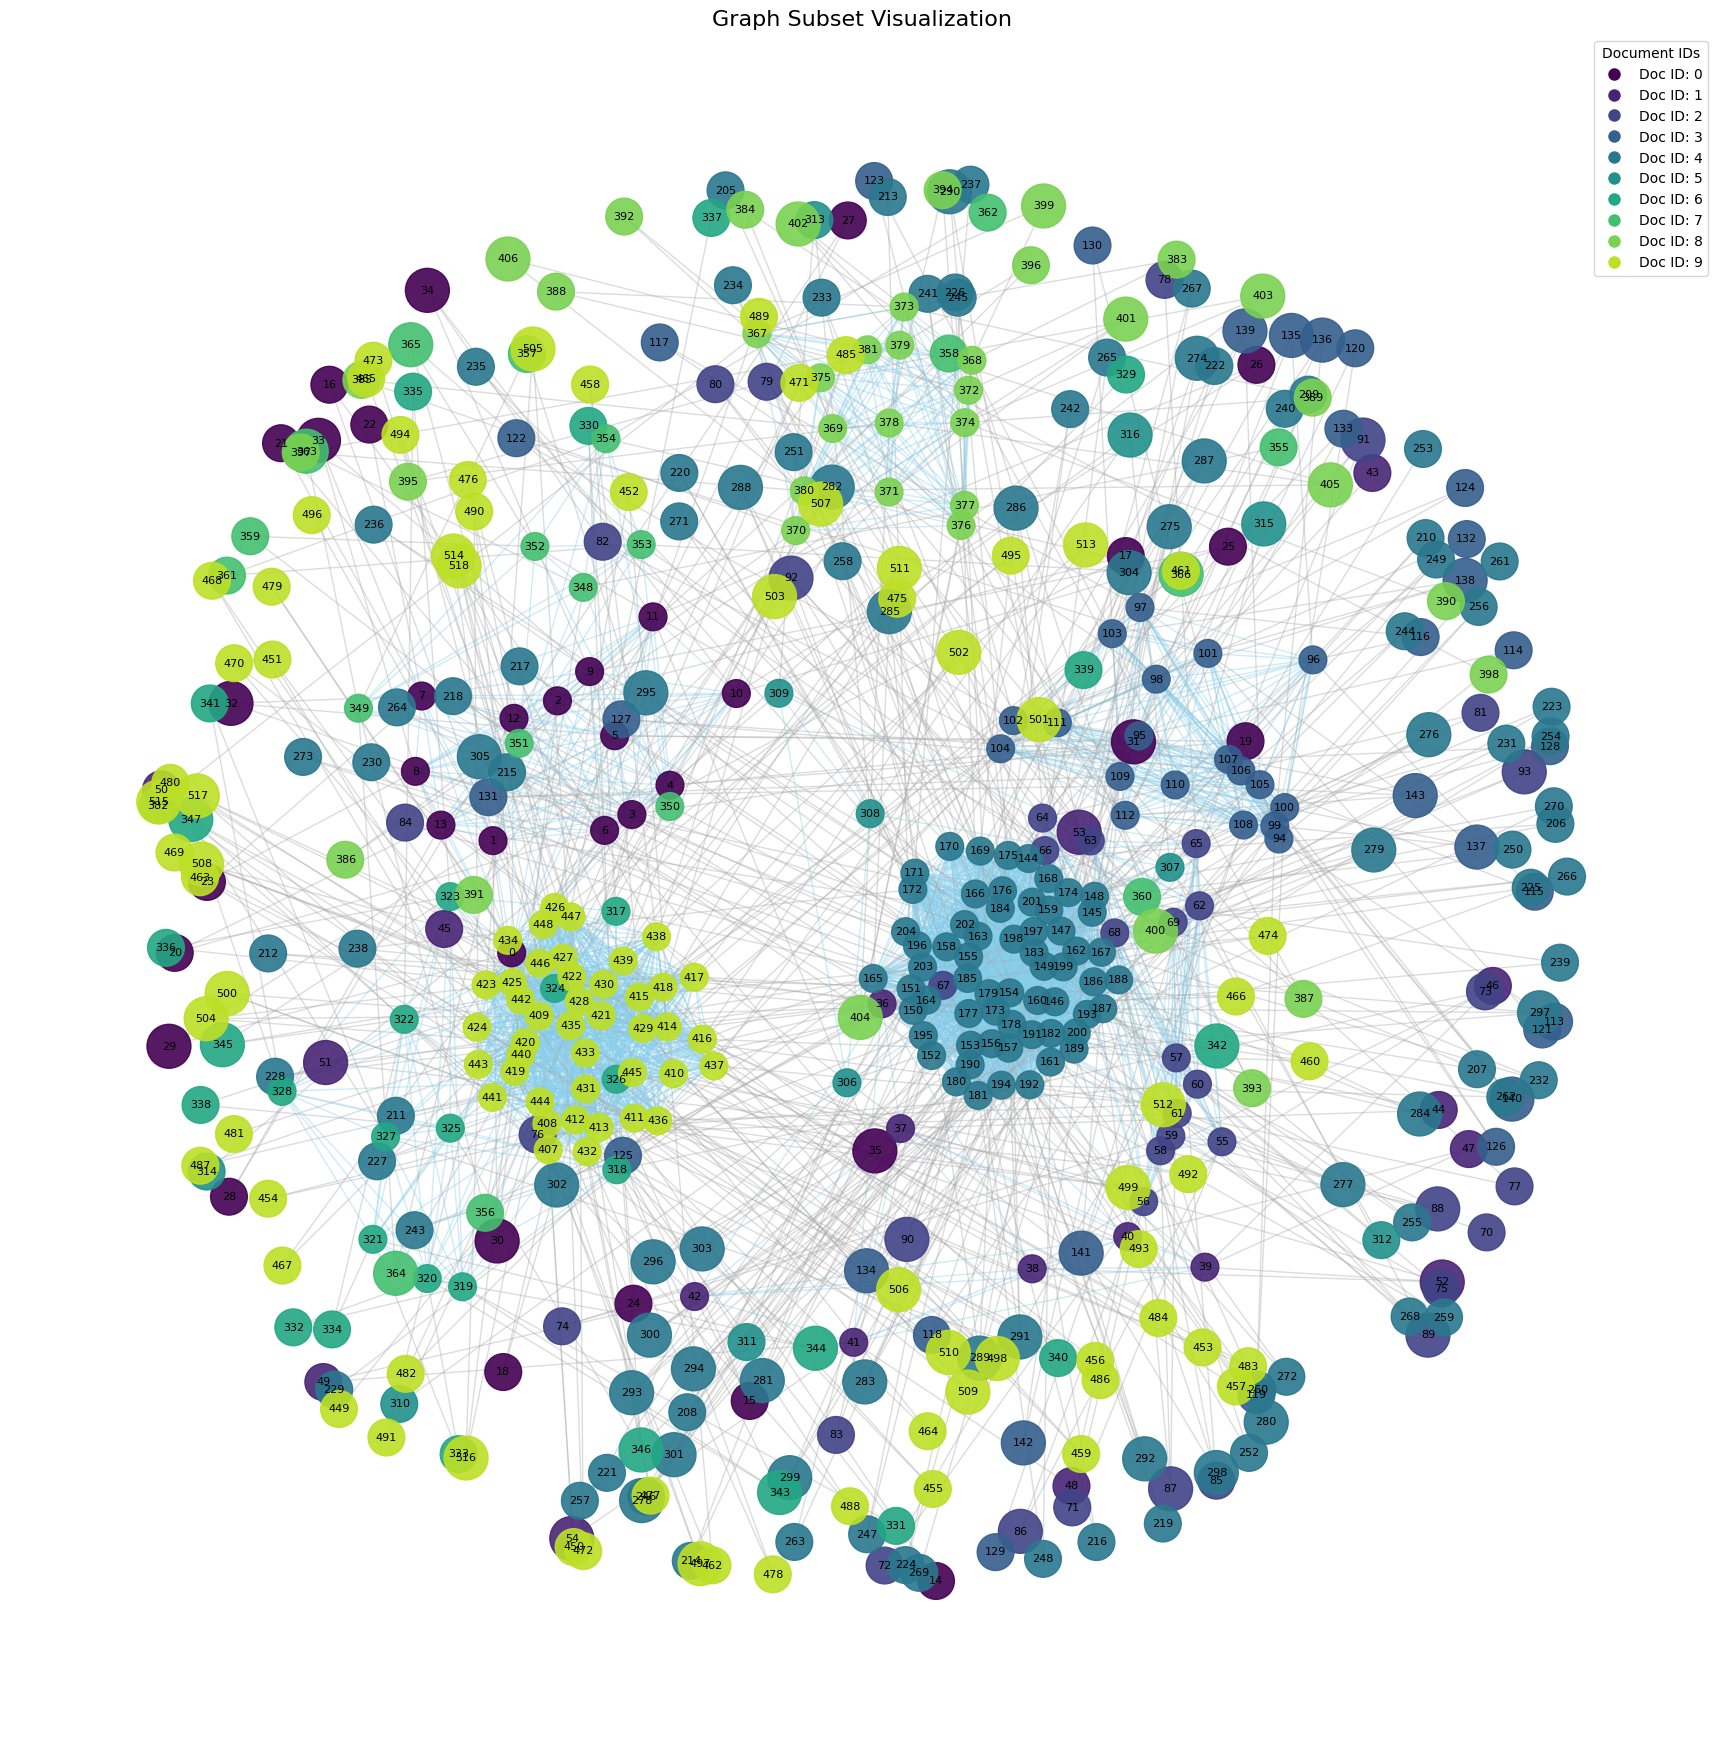

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random

# Ensure the graph G and hybrid_chunks_df are available
if 'G' not in locals() or 'hybrid_chunks_df' not in locals() or hybrid_chunks_df.empty:
    print("Graph G or hybrid_chunks_df not available. Please load them first.")
else:
    # ================================
    # DEFINE THE NODE OR EDGE SELECTION LOGIC BELOW
    # ================================

    # --- OPTION 1: Visualize the first N documents ---
    # doc_ids_to_visualize = hybrid_chunks_df['doc_id'].unique()[:10].tolist()

    # --- OPTION 2: Visualize all documents of a specific category ---
    # target_category = 'Service Agreement'
    # doc_ids_to_visualize = hybrid_chunks_df[hybrid_chunks_df['category'] == target_category]['doc_id'].unique().tolist()

    # --- OPTION 3: Visualize only Full Document chunks ---
    # nodes_to_visualize = [node for node, data in G.nodes(data=True) if data.get('level') == 'full']
    # subgraph = G.subgraph(nodes_to_visualize)

    # --- OPTION 4: Visualize only Semantic Similarity edges ---
    # semantic_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('type') == 'semantic_similarity']
    # subgraph = G.edge_subgraph(semantic_edges)

    # --- OPTION 5: Visualize a random sample of N nodes ---
    sampled_nodes = random.sample(list(G.nodes()), min(8, G.number_of_nodes()))
    subgraph = G.subgraph(sampled_nodes)

   



    # --- OPTION 6: Visualize only L1 level chunks ---
    # nodes_to_visualize = [node for node, data in G.nodes(data=True) if data.get('level') == 'L1']
    # subgraph = G.subgraph(nodes_to_visualize)

    # Uncomment ONE of the above or use the default below
    nodes_for_multi_doc_subgraph = [
        node for node, data in G.nodes(data=True) 
        if data.get('doc_id') in doc_ids_to_visualize
    ]
    subgraph = G.subgraph(nodes_for_multi_doc_subgraph)

    if subgraph.number_of_nodes() == 0:
        print("No nodes found for the selected condition.")
    else:
        print(f"Subgraph created with {subgraph.number_of_nodes()} nodes and {subgraph.number_of_edges()} edges.")

        plt.figure(figsize=(22, 22))

        # --- Change layout here if desired ---
        try:
            pos = nx.spring_layout(subgraph, k=0.6, iterations=70, seed=42)
        except:
            pos = nx.random_layout(subgraph, seed=42)

        # Color nodes by document ID if available
        doc_ids = list(set(nx.get_node_attributes(subgraph, 'doc_id').values()))
        doc_id_color_map = {doc_id: plt.cm.get_cmap('viridis')(i/len(doc_ids)) for i, doc_id in enumerate(doc_ids)}

        node_colors = []
        node_sizes = []
        for node, data in subgraph.nodes(data=True):
            doc_id = data.get('doc_id')
            node_colors.append(doc_id_color_map.get(doc_id, 'grey'))

            level = data.get('level', 'other')
            if level == 'full_document':
                node_sizes.append(1500)
            elif level == 'L3':
                node_sizes.append(1000)
            elif level == 'L2':
                node_sizes.append(700)
            elif level == 'L1':
                node_sizes.append(400)
            else:
                node_sizes.append(300)

        nx.draw_networkx_nodes(subgraph, pos, node_size=node_sizes, node_color=node_colors, alpha=0.9)

        # Edge styling by type
        edge_types = nx.get_edge_attributes(subgraph, 'type')
        edge_colors_map = {
            'hierarchical_child_to_parent': 'gray',
            'hierarchical_parent_to_child': 'darkgray',
            'same_document_l1': 'skyblue',
            'semantic_similarity': 'lightcoral'
        }
        default_edge_color = 'lightgrey'
        edge_colors = [edge_colors_map.get(edge_types.get(edge), default_edge_color) for edge in subgraph.edges()]

        nx.draw_networkx_edges(subgraph, pos, width=1.0, alpha=0.4, edge_color=edge_colors)

        # Node Labels (show chunk_id or any attribute you prefer)
        node_labels = {node: data.get('chunk_id', node) for node, data in subgraph.nodes(data=True)}
        nx.draw_networkx_labels(subgraph, pos, labels=node_labels, font_size=8)

        # Legend for document IDs
        doc_legend_handles = [
            plt.Line2D([0], [0], marker='o', color='w', label=f"Doc ID: {doc_id}",
                       markersize=10, markerfacecolor=color)
            for doc_id, color in doc_id_color_map.items()
        ]
        plt.legend(handles=doc_legend_handles, title="Document IDs", loc='best')

        plt.title("Graph Subset Visualization", fontsize=16)
        plt.axis('off')
        plt.show()


### Randomized Graph Inspection and Visualization

To further ensure the graph is constructed as expected, we can visualize random parts of it. This helps in spotting anomalies or verifying typical connection patterns.

We can try:
1.  **Visualizing a random node and its immediate neighborhood:** This shows the direct connections of a randomly chosen chunk.
2.  **Visualizing a small, random subgraph:** This gives a glimpse into a randomly selected portion of the overall graph structure.

Graph G has 6434 nodes and 46842 edges.
Visualizing random node '3834' (and its 2 neighbors). Subgraph has 3 nodes, 3 edges.


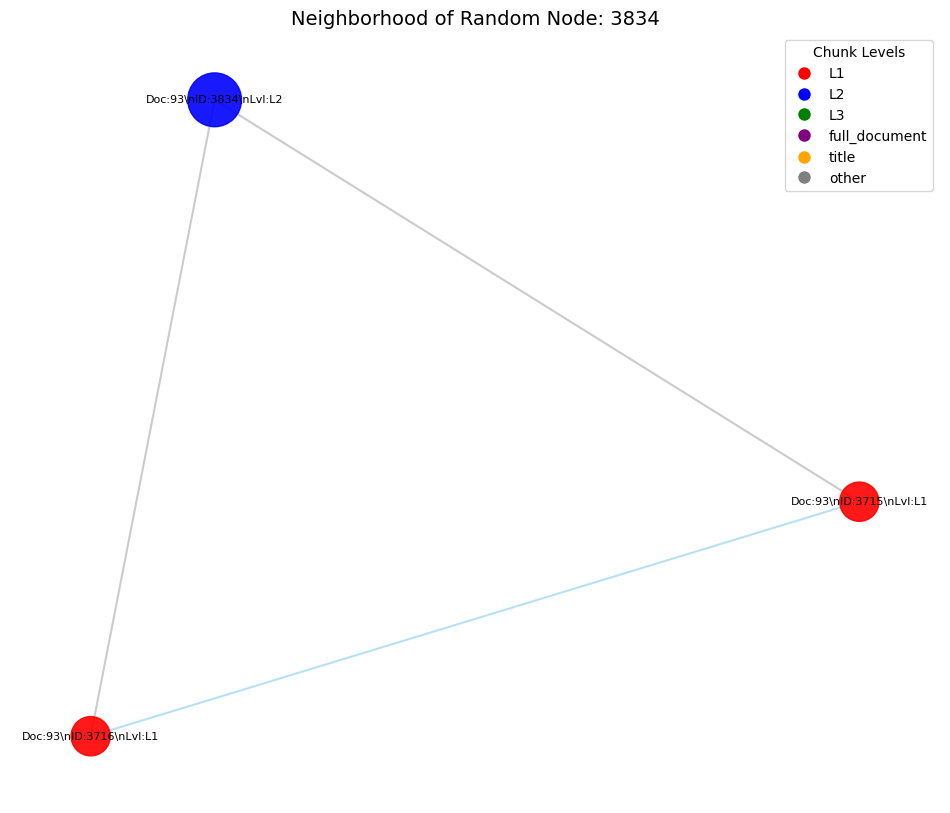

\nVisualizing a random subgraph. Initially selected 30 nodes. Subgraph has 30 nodes, 0 edges.


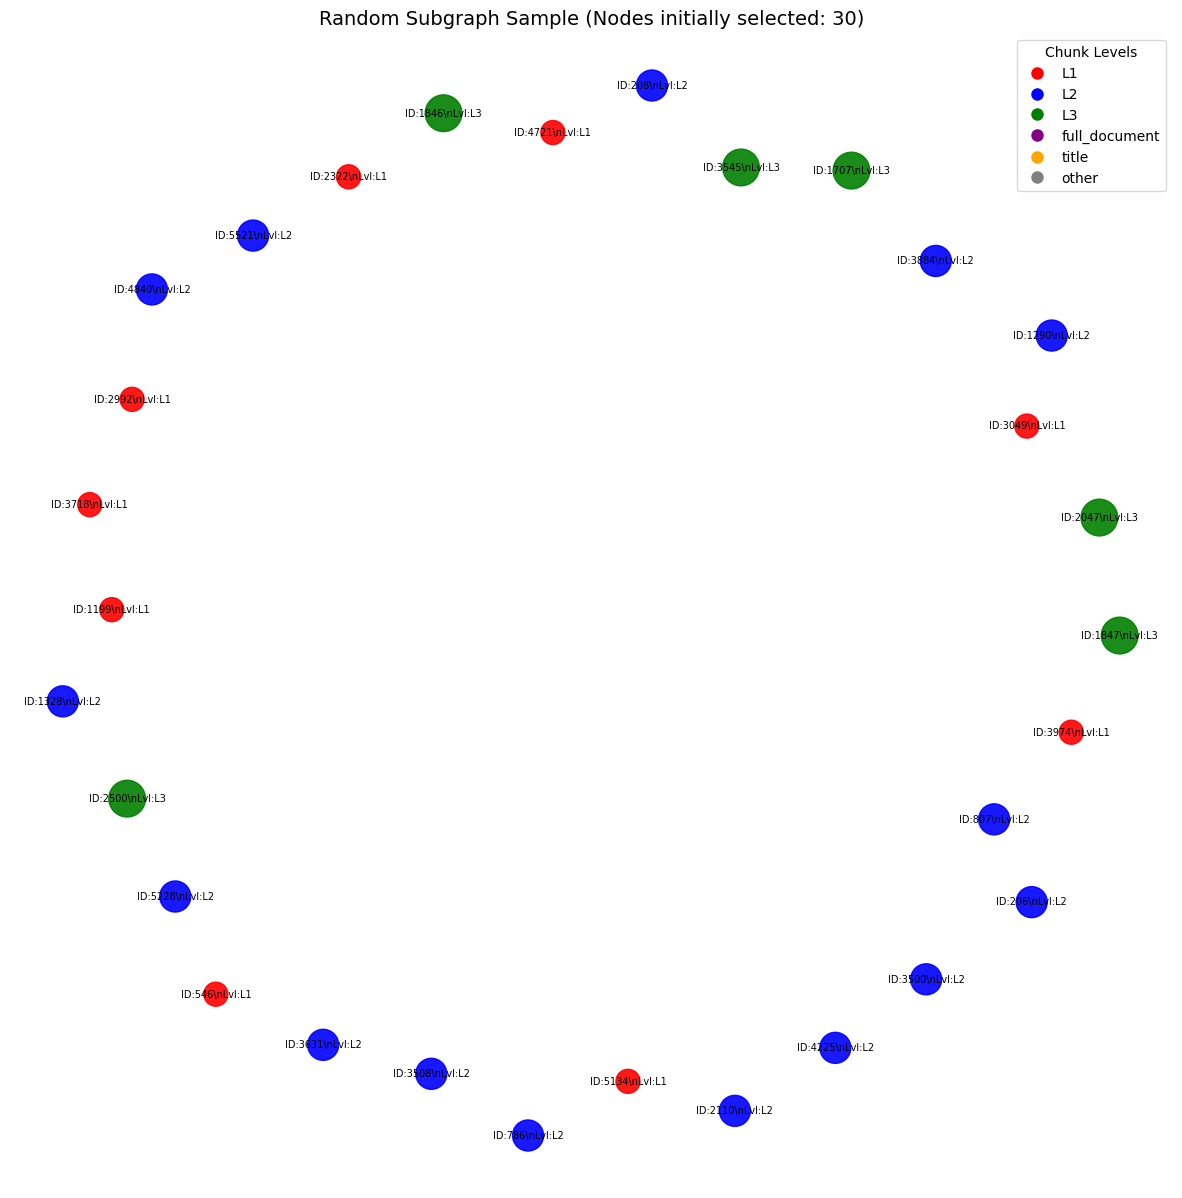

In [18]:
import matplotlib.pyplot as plt
import networkx as nx
import random
import numpy as np # ensure numpy is imported

if 'G' not in locals() or G.number_of_nodes() == 0:
    print("Graph G is not available or is empty. Please run previous cells to create/load it.")
else:
    print(f"Graph G has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

    # --- Option 1: Visualize a random node and its neighbors ---
    if G.number_of_nodes() > 0:
        random_node_id = random.choice(list(G.nodes()))
        neighbors = list(G.neighbors(random_node_id))
        nodes_to_visualize_option1 = [random_node_id] + neighbors
        
        subgraph_option1 = G.subgraph(nodes_to_visualize_option1) # Create subgraph

        if subgraph_option1.number_of_nodes() == 0:
             print(f"Selected random node {random_node_id} resulted in an empty subgraph. This is unexpected.")
        else:
            if not neighbors:
                 print(f"Visualizing isolated random node '{random_node_id}' (it has 0 neighbors).")
            else:
                print(f"Visualizing random node '{random_node_id}' (and its {len(neighbors)} neighbors). Subgraph has {subgraph_option1.number_of_nodes()} nodes, {subgraph_option1.number_of_edges()} edges.")

            plt.figure(figsize=(12, 10))
            try:
                pos_op1 = nx.spring_layout(subgraph_option1, k=0.8, iterations=50, seed=42)
            except Exception as e:
                print(f"Spring layout failed for Option 1 ({e}), falling back to random layout.")
                pos_op1 = nx.random_layout(subgraph_option1, seed=42) # Fallback
            
            node_colors_op1 = []
            node_labels_op1 = {}
            node_sizes_op1 = []
            levels_color_map = {'L1': 'red', 'L2': 'blue', 'L3': 'green', 'full_document': 'purple', 'title': 'orange', 'other': 'grey'}

            for node, data in subgraph_option1.nodes(data=True):
                level = data.get('level', 'other')
                node_colors_op1.append(levels_color_map.get(level, 'grey'))
                node_labels_op1[node] = f"Doc:{data.get('doc_id', 'N/A')}\\nID:{str(node)[:8]}\\nLvl:{level}"
                if node == random_node_id:
                    node_sizes_op1.append(1500)
                else:
                    node_sizes_op1.append(800)

            nx.draw_networkx_nodes(subgraph_option1, pos_op1, node_size=node_sizes_op1, node_color=node_colors_op1, alpha=0.9)
            
            edge_types_op1 = nx.get_edge_attributes(subgraph_option1, 'type')
            edge_colors_map = {'hierarchical_child_to_parent': 'gray', 
                               'hierarchical_parent_to_child': 'darkgray', 
                               'same_document_l1': 'skyblue', 
                               'semantic_similarity': 'lightcoral'}
            default_edge_color = 'lightgrey'
            
            edge_list_op1 = list(subgraph_option1.edges(data=True))
            colors_for_edges_op1 = [edge_colors_map.get(data.get('type'), default_edge_color) for u,v,data in edge_list_op1]
            
            nx.draw_networkx_edges(subgraph_option1, pos_op1, edgelist=edge_list_op1, width=1.5, alpha=0.6, edge_color=colors_for_edges_op1)
            nx.draw_networkx_labels(subgraph_option1, pos_op1, labels=node_labels_op1, font_size=8)
            
            legend_handles_op1 = [plt.Line2D([0], [0], marker='o', color='w', label=level, 
                                     markersize=10, markerfacecolor=color) for level, color in levels_color_map.items()]
            plt.legend(handles=legend_handles_op1, title="Chunk Levels", loc='best')

            plt.title(f"Neighborhood of Random Node: {random_node_id}", fontsize=14)
            plt.axis('off')
            plt.show()
    else:
        print("Graph has no nodes to select for random node visualization.")

    # --- Option 2: Visualize a small random subgraph --- 
    num_nodes_for_random_subgraph = min(30, G.number_of_nodes()) 
    if G.number_of_nodes() >= 2 and num_nodes_for_random_subgraph > 1:
        random_nodes_for_subgraph = random.sample(list(G.nodes()), num_nodes_for_random_subgraph)
        subgraph_option2 = G.subgraph(random_nodes_for_subgraph).copy() 
        
        # Optional: Remove isolated nodes from this random sample for a potentially cleaner visualization
        # isolated_nodes = [node for node in subgraph_option2.nodes() if subgraph_option2.degree(node) == 0]
        # subgraph_option2.remove_nodes_from(isolated_nodes)
        
        if subgraph_option2.number_of_nodes() > 0:
            print(f"\\nVisualizing a random subgraph. Initially selected {num_nodes_for_random_subgraph} nodes. Subgraph has {subgraph_option2.number_of_nodes()} nodes, {subgraph_option2.number_of_edges()} edges.")
            plt.figure(figsize=(15, 15))
            try:
                pos_op2 = nx.spring_layout(subgraph_option2, k=0.7, iterations=60, seed=123)
            except Exception as e:
                print(f"Spring layout failed for Option 2 ({e}), trying kamada_kawai layout.")
                try:
                    pos_op2 = nx.kamada_kawai_layout(subgraph_option2) 
                except Exception as e2:
                    print(f"Kamada_kawai layout also failed for Option 2 ({e2}), falling back to random layout.")
                    pos_op2 = nx.random_layout(subgraph_option2, seed=123)


            node_colors_op2 = []
            node_labels_op2 = {}
            node_sizes_op2 = []
            
            levels_color_map = {'L1': 'red', 'L2': 'blue', 'L3': 'green', 'full_document': 'purple', 'title': 'orange', 'other': 'grey'}
            unique_docs_in_subgraph = list(set(data.get('doc_id') for _, data in subgraph_option2.nodes(data=True) if data.get('doc_id') is not None))
            
            legend_handles_op2 = []
            legend_title_op2 = ""

            if len(unique_docs_in_subgraph) > 1 and len(unique_docs_in_subgraph) < 10: 
                doc_id_color_map_op2 = {doc_id: plt.cm.get_cmap('tab10')(i/len(unique_docs_in_subgraph)) 
                                        for i, doc_id in enumerate(unique_docs_in_subgraph)}
                for node, data in subgraph_option2.nodes(data=True):
                    doc_id = data.get('doc_id')
                    node_colors_op2.append(doc_id_color_map_op2.get(doc_id, 'lightgrey'))
                    node_labels_op2[node] = f"Doc:{doc_id}\\nID:{str(node)[:6]}\\nLvl:{data.get('level', 'N/A')}"
                    level = data.get('level', 'other')
                    node_sizes_op2.append(300 + 200 * (list(levels_color_map.keys()).index(level) if level in levels_color_map else 0))
                
                legend_handles_op2 = [plt.Line2D([0], [0], marker='o', color='w', label=f"Doc ID: {doc_id}", 
                                     markersize=10, markerfacecolor=color) for doc_id, color in doc_id_color_map_op2.items()]
                legend_title_op2 = "Document IDs"
            else: 
                for node, data in subgraph_option2.nodes(data=True):
                    level = data.get('level', 'other')
                    node_colors_op2.append(levels_color_map.get(level, 'grey'))
                    node_labels_op2[node] = f"ID:{str(node)[:10]}\\nLvl:{level}"
                    node_sizes_op2.append(300 + 200 * (list(levels_color_map.keys()).index(level) if level in levels_color_map else 0))

                legend_handles_op2 = [plt.Line2D([0], [0], marker='o', color='w', label=level, 
                                     markersize=10, markerfacecolor=color) for level, color in levels_color_map.items()]
                legend_title_op2 = "Chunk Levels"

            nx.draw_networkx_nodes(subgraph_option2, pos_op2, node_size=node_sizes_op2, node_color=node_colors_op2, alpha=0.9)
            
            edge_types_op2 = nx.get_edge_attributes(subgraph_option2, 'type')
            edge_colors_map = {'hierarchical_child_to_parent': 'gray', 
                               'hierarchical_parent_to_child': 'darkgray', 
                               'same_document_l1': 'skyblue', 
                               'semantic_similarity': 'lightcoral'}
            default_edge_color = 'lightgrey'

            edge_list_op2 = list(subgraph_option2.edges(data=True))
            colors_for_edges_op2 = [edge_colors_map.get(data.get('type'), default_edge_color) for u,v,data in edge_list_op2]

            nx.draw_networkx_edges(subgraph_option2, pos_op2, edgelist=edge_list_op2, width=1.0, alpha=0.5, edge_color=colors_for_edges_op2)
            nx.draw_networkx_labels(subgraph_option2, pos_op2, labels=node_labels_op2, font_size=7)
            
            if legend_handles_op2: 
                plt.legend(handles=legend_handles_op2, title=legend_title_op2, loc='best')

            plt.title(f"Random Subgraph Sample (Nodes initially selected: {num_nodes_for_random_subgraph})", fontsize=14)
            plt.axis('off')
            plt.show()
        else:
            print("Could not form a non-empty random subgraph with the selected nodes (possibly all were isolated and removed).")
    elif G.number_of_nodes() > 0 :
        print("\\nNot enough nodes in the graph to form a meaningful random subgraph for Option 2 (need at least 2).")
    else:
        print("\\nGraph has no nodes to select for random subgraph visualization.")


### Enhanced Graph Construction Logic

The following section details the updated graph construction process, incorporating several improvements for a more comprehensive and robust analysis, especially relevant for legal documents:

1.  **Comprehensive Semantic Similarity for All L1 Chunks:**
    *   **Change:** Instead of sampling a small subset of L1 chunks (e.g., 100), the script now processes **all** L1 chunks to identify and add semantic similarity edges.
    *   **Reasoning:** In legal document analysis, every piece of information can be critical. Processing all L1 chunks ensures that no potentially important semantic connections are missed due to sampling.
    *   **Impact:** This significantly increases the number of potential semantic edges, leading to a denser and more interconnected graph. It is more computationally intensive and may require more time to execute, especially with a large number of L1 chunks.

2.  **Edge Weights for All Edge Types:**
    *   **Change:** All edges added to the graph now include a `weight` attribute.
        *   `semantic_similarity` edges: The weight is the cosine similarity score (e.g., values between your threshold like 0.6 and 1.0).
        *   `hierarchical_child_to_parent`, `hierarchical_parent_to_child`, and `same_document_l1` edges: These are assigned a default weight of `1.0`.
    *   **Reasoning:** Assigning weights consistently across all edge types can be beneficial for various graph algorithms and GNN models that can utilize edge weights to modulate the strength or importance of connections.

3.  **Node Degree as an Attribute:**
    *   **Change:** After the graph is fully constructed (all nodes and edges added), the script calculates the degree for each node (i.e., the number of edges connected to it) and stores this value as a node attribute named `degree`.
    *   **Reasoning:** Node degree is a fundamental graph metric. It can be used for:
        *   Identifying highly connected (potentially important) chunks.
        *   Filtering or ranking nodes.
        *   As a feature in GNN models.

4.  **Graph Type - Undirected (`nx.Graph()`):**
    *   **Change (Confirmation):** The graph continues to be an `nx.Graph()`, meaning it is undirected.
    *   **Reasoning:**
        *   `semantic_similarity` and `same_document_l1` relationships are inherently undirected.
        *   While hierarchical relationships (`parent-child`) are directional, the current edge `type` attributes (e.g., `hierarchical_child_to_parent`, `hierarchical_parent_to_child`) explicitly convey this directionality within the undirected graph structure.
        *   If strict enforcement of directionality becomes critical for specific GNN architectures or analyses, switching to `nx.DiGraph()` would be a consideration. However, for mixed-type relationships, `nx.Graph()` with descriptive edge types is often a practical starting point.

5.  **Subgraph Display for a Random Document:**
    *   **Change:** The example code snippet for displaying a subgraph at the end of the construction process now selects a **random document ID** from the dataset, rather than always picking the first one.
    *   **Reasoning:** This provides a more varied and potentially more representative quick look into the structure of individual documents within the larger graph during different runs.

**Further Considerations (Not directly implemented in the immediate script but important for scaling and production):**

*   **Scalability of Semantic Similarity:** Calculating a full N x N cosine similarity matrix for a very large number of L1 chunks (e.g., hundreds of thousands or millions) can be memory and computationally prohibitive. For such scenarios, advanced techniques are recommended:
    *   **Approximate Nearest Neighbor (ANN) search:** Libraries like FAISS or Annoy can find the most similar items without computing the full matrix.
    *   **Batch Processing:** Compute similarities in smaller batches.
    *   **Distributed Computing:** Use frameworks like Spark.
*   **Python Typing and Logging:** For larger projects or production code, incorporating Python's `typing` module for type hints and the `logging` module for structured logging significantly improves code readability, maintainability, and debugging.

These enhancements aim to create a more detailed and analytically useful graph from your legal documents, paving the way for more effective GNN-based analysis.

In [19]:
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np # Ensure numpy is imported
import random # For random document selection

# Initialize a new graph
G = nx.Graph()

if 'hybrid_chunks_df' in locals() and not hybrid_chunks_df.empty:
    # Add nodes with attributes from hybrid_chunks_df
    for idx, row in hybrid_chunks_df.iterrows():
        G.add_node(
            row['chunk_id'],
            doc_id=row['doc_id'],
            doc_name=row['doc_name'],
            category=row['category'],
            text=row['text'][:100] + '...' if len(row['text']) > 100 else row['text'],
            level=row['level'],
            chunk_method=row['chunk_method'],
            start_idx=row['start_idx'],
            end_idx=row['end_idx'],
            is_special_section=row.get('is_special_section', False),
            section_type=row.get('section_type', None),
            embedding=row['embedding']
        )
    print(f"Added {G.number_of_nodes()} nodes to the graph.")

    # Add hierarchical and same-document edges
    hierarchical_edge_count = 0
    same_doc_l1_edge_count = 0

    for idx, row in hybrid_chunks_df.iterrows():
        current_chunk_id = row['chunk_id']
        relationships = row.get('chunk_relationships', {})

        # Hierarchical parent edges (L1 to L2/L3/full)
        if relationships.get('hierarchical_parents'):
            for parent_id in relationships['hierarchical_parents']:
                if G.has_node(parent_id) and G.has_node(current_chunk_id):
                    if not G.has_edge(current_chunk_id, parent_id): # Avoid duplicates if relationship is symmetric in data
                        G.add_edge(current_chunk_id, parent_id, type='hierarchical_child_to_parent', weight=1.0)
                        hierarchical_edge_count += 1

        # Contained chunk edges (L2/L3/full to L1)
        if row.get('contained_chunks') and isinstance(row['contained_chunks'], list):
            for child_id in row['contained_chunks']:
                if G.has_node(child_id) and G.has_node(current_chunk_id):
                    if not G.has_edge(current_chunk_id, child_id): # Avoid duplicates
                        G.add_edge(current_chunk_id, child_id, type='hierarchical_parent_to_child', weight=1.0)
                        # This might double count if hierarchical_parents also creates the reverse edge.
                        # Depending on data structure, one of these might be sufficient or need careful deduplication.
                        # For now, we assume they might represent distinct definitions or ensure no duplicates.
                        hierarchical_edge_count +=1 # Count only if truly new

        # Same document L1 chunk edges
        if row['level'] == 'L1' and relationships.get('same_doc_l1_chunks'):
            for same_doc_l1_id in relationships['same_doc_l1_chunks']:
                if G.has_node(same_doc_l1_id) and G.has_node(current_chunk_id) and current_chunk_id != same_doc_l1_id:
                    if not G.has_edge(current_chunk_id, same_doc_l1_id):
                        G.add_edge(current_chunk_id, same_doc_l1_id, type='same_document_l1', weight=1.0)
                        same_doc_l1_edge_count += 1

    print(f"Added {hierarchical_edge_count} hierarchical edges (child-parent/parent-child).")
    print(f"Added {same_doc_l1_edge_count} same-document L1 edges.")

    # Add semantic similarity edges for ALL L1 chunks
    l1_chunks_df = hybrid_chunks_df[hybrid_chunks_df['level'] == 'L1'].copy() # Use .copy() to avoid SettingWithCopyWarning
    semantic_edge_count = 0
    similarity_threshold = 0.6 # Your adjusted threshold

    if not l1_chunks_df.empty and 'embedding' in l1_chunks_df.columns:
        l1_chunk_ids = l1_chunks_df['chunk_id'].tolist()
        l1_embeddings = np.array(l1_chunks_df['embedding'].tolist())

        if l1_embeddings.ndim == 2 and l1_embeddings.shape[0] > 0:
            print(f"Calculating cosine similarity matrix for {l1_embeddings.shape[0]} L1 chunks. This may take some time...")
            cosine_sim_matrix = cosine_similarity(l1_embeddings)
            print("Cosine similarity matrix calculated.")

            for i in range(len(l1_chunk_ids)):
                for j in range(i + 1, len(l1_chunk_ids)): # Avoid self-loops and duplicate edges
                    if cosine_sim_matrix[i, j] > similarity_threshold:
                        node1_id = l1_chunk_ids[i]
                        node2_id = l1_chunk_ids[j]
                        # Ensure nodes exist (should always be true here) and edge doesn't already exist
                        if G.has_node(node1_id) and G.has_node(node2_id):
                            if not G.has_edge(node1_id, node2_id):
                                G.add_edge(node1_id, node2_id, type='semantic_similarity', weight=float(cosine_sim_matrix[i, j]))
                                semantic_edge_count += 1
            print(f"Added {semantic_edge_count} semantic similarity edges between L1 chunks (threshold: {similarity_threshold}).")
        elif l1_embeddings.shape[0] == 0:
            print("No L1 chunk embeddings found to process for semantic similarity.")
        else:
            print("Embeddings for L1 chunks are not in the expected 2D array format.")
    else:
        print("No L1 chunks or 'embedding' column found in l1_chunks_df to calculate semantic similarity.")

    # Add node degree as an attribute
    for node_id in G.nodes():
        G.nodes[node_id]['degree'] = G.degree(node_id)
    print("Added 'degree' attribute to all nodes.")

    print(f"Total nodes in graph: {G.number_of_nodes()}")
    print(f"Total edges in graph: {G.number_of_edges()}")

    # Display a small part of the graph (e.g., nodes and edges related to one RANDOM document)
    unique_doc_ids = hybrid_chunks_df['doc_id'].unique()
    if len(unique_doc_ids) > 0:
        sample_doc_id = random.choice(unique_doc_ids)
        print(f"\n--- Subgraph display for a random document (ID: {sample_doc_id}) ---")
        nodes_of_sample_doc = [node for node, data in G.nodes(data=True) if data.get('doc_id') == sample_doc_id]

        if nodes_of_sample_doc:
            subgraph_sample_doc = G.subgraph(nodes_of_sample_doc)
            print(f"Subgraph for document ID {sample_doc_id} has {subgraph_sample_doc.number_of_nodes()} nodes and {subgraph_sample_doc.number_of_edges()} edges.")
            # Example: Print some node attributes from the subgraph
            for i, (node_id, data) in enumerate(list(subgraph_sample_doc.nodes(data=True))[:3]): # Print first 3 nodes
                print(f"  Node {node_id}: Level='{data.get('level')}', Degree='{data.get('degree')}', Text Snippet='{data.get('text', '')[:30]}...'")
            # Example: Print some edge attributes from the subgraph
            for i, (u,v,data) in enumerate(list(subgraph_sample_doc.edges(data=True))[:3]): # Print first 3 edges
                 print(f"  Edge ({u} - {v}): Type='{data.get('type')}', Weight='{data.get('weight')}'")
        else:
            print(f"No nodes found for sample document ID {sample_doc_id}.")
    else:
        print("No document IDs available to sample for subgraph display.")

else:
    print("hybrid_chunks_df is not defined or is empty. Cannot build graph.")


Added 6434 nodes to the graph.
Added 8526 hierarchical edges (child-parent/parent-child).
Added 38265 same-document L1 edges.
Calculating cosine similarity matrix for 2443 L1 chunks. This may take some time...
Cosine similarity matrix calculated.
Added 8526 hierarchical edges (child-parent/parent-child).
Added 38265 same-document L1 edges.
Calculating cosine similarity matrix for 2443 L1 chunks. This may take some time...
Cosine similarity matrix calculated.
Added 27723 semantic similarity edges between L1 chunks (threshold: 0.6).
Added 'degree' attribute to all nodes.
Total nodes in graph: 6434
Total edges in graph: 74514

--- Subgraph display for a random document (ID: 5) ---
Subgraph for document ID 5 has 11 nodes and 19 edges.
  Node 306: Level='L1', Degree='51', Text Snippet='ExhibitCONTENT LICENSING AGREE...'
  Node 307: Level='L1', Degree='82', Text Snippet='respective applying value adde...'
  Node 308: Level='L1', Degree='32', Text Snippet='question (including all copies...'
 


### Advanced Graph Subset Visualization

This cell provides multiple options to visualize different subsets of the graph `G`.
Uncomment one of the "OPTION" blocks to select the nodes or edges you want to focus on.
The visualization will adapt to show node colors by document ID (if multiple documents are present in the selection) or by chunk level, node sizes by chunk level, and edge colors by their type.


Plotting: Subgraph for First 3 Documents
Subgraph contains 94 nodes and 349 edges.


C:\Users\Thevindu Kalubowila\AppData\Local\Temp\ipykernel_19480\3621011504.py:130: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  doc_id_color_map = {doc_id: plt.cm.get_cmap('tab20')(i/len(unique_doc_ids_in_subgraph))


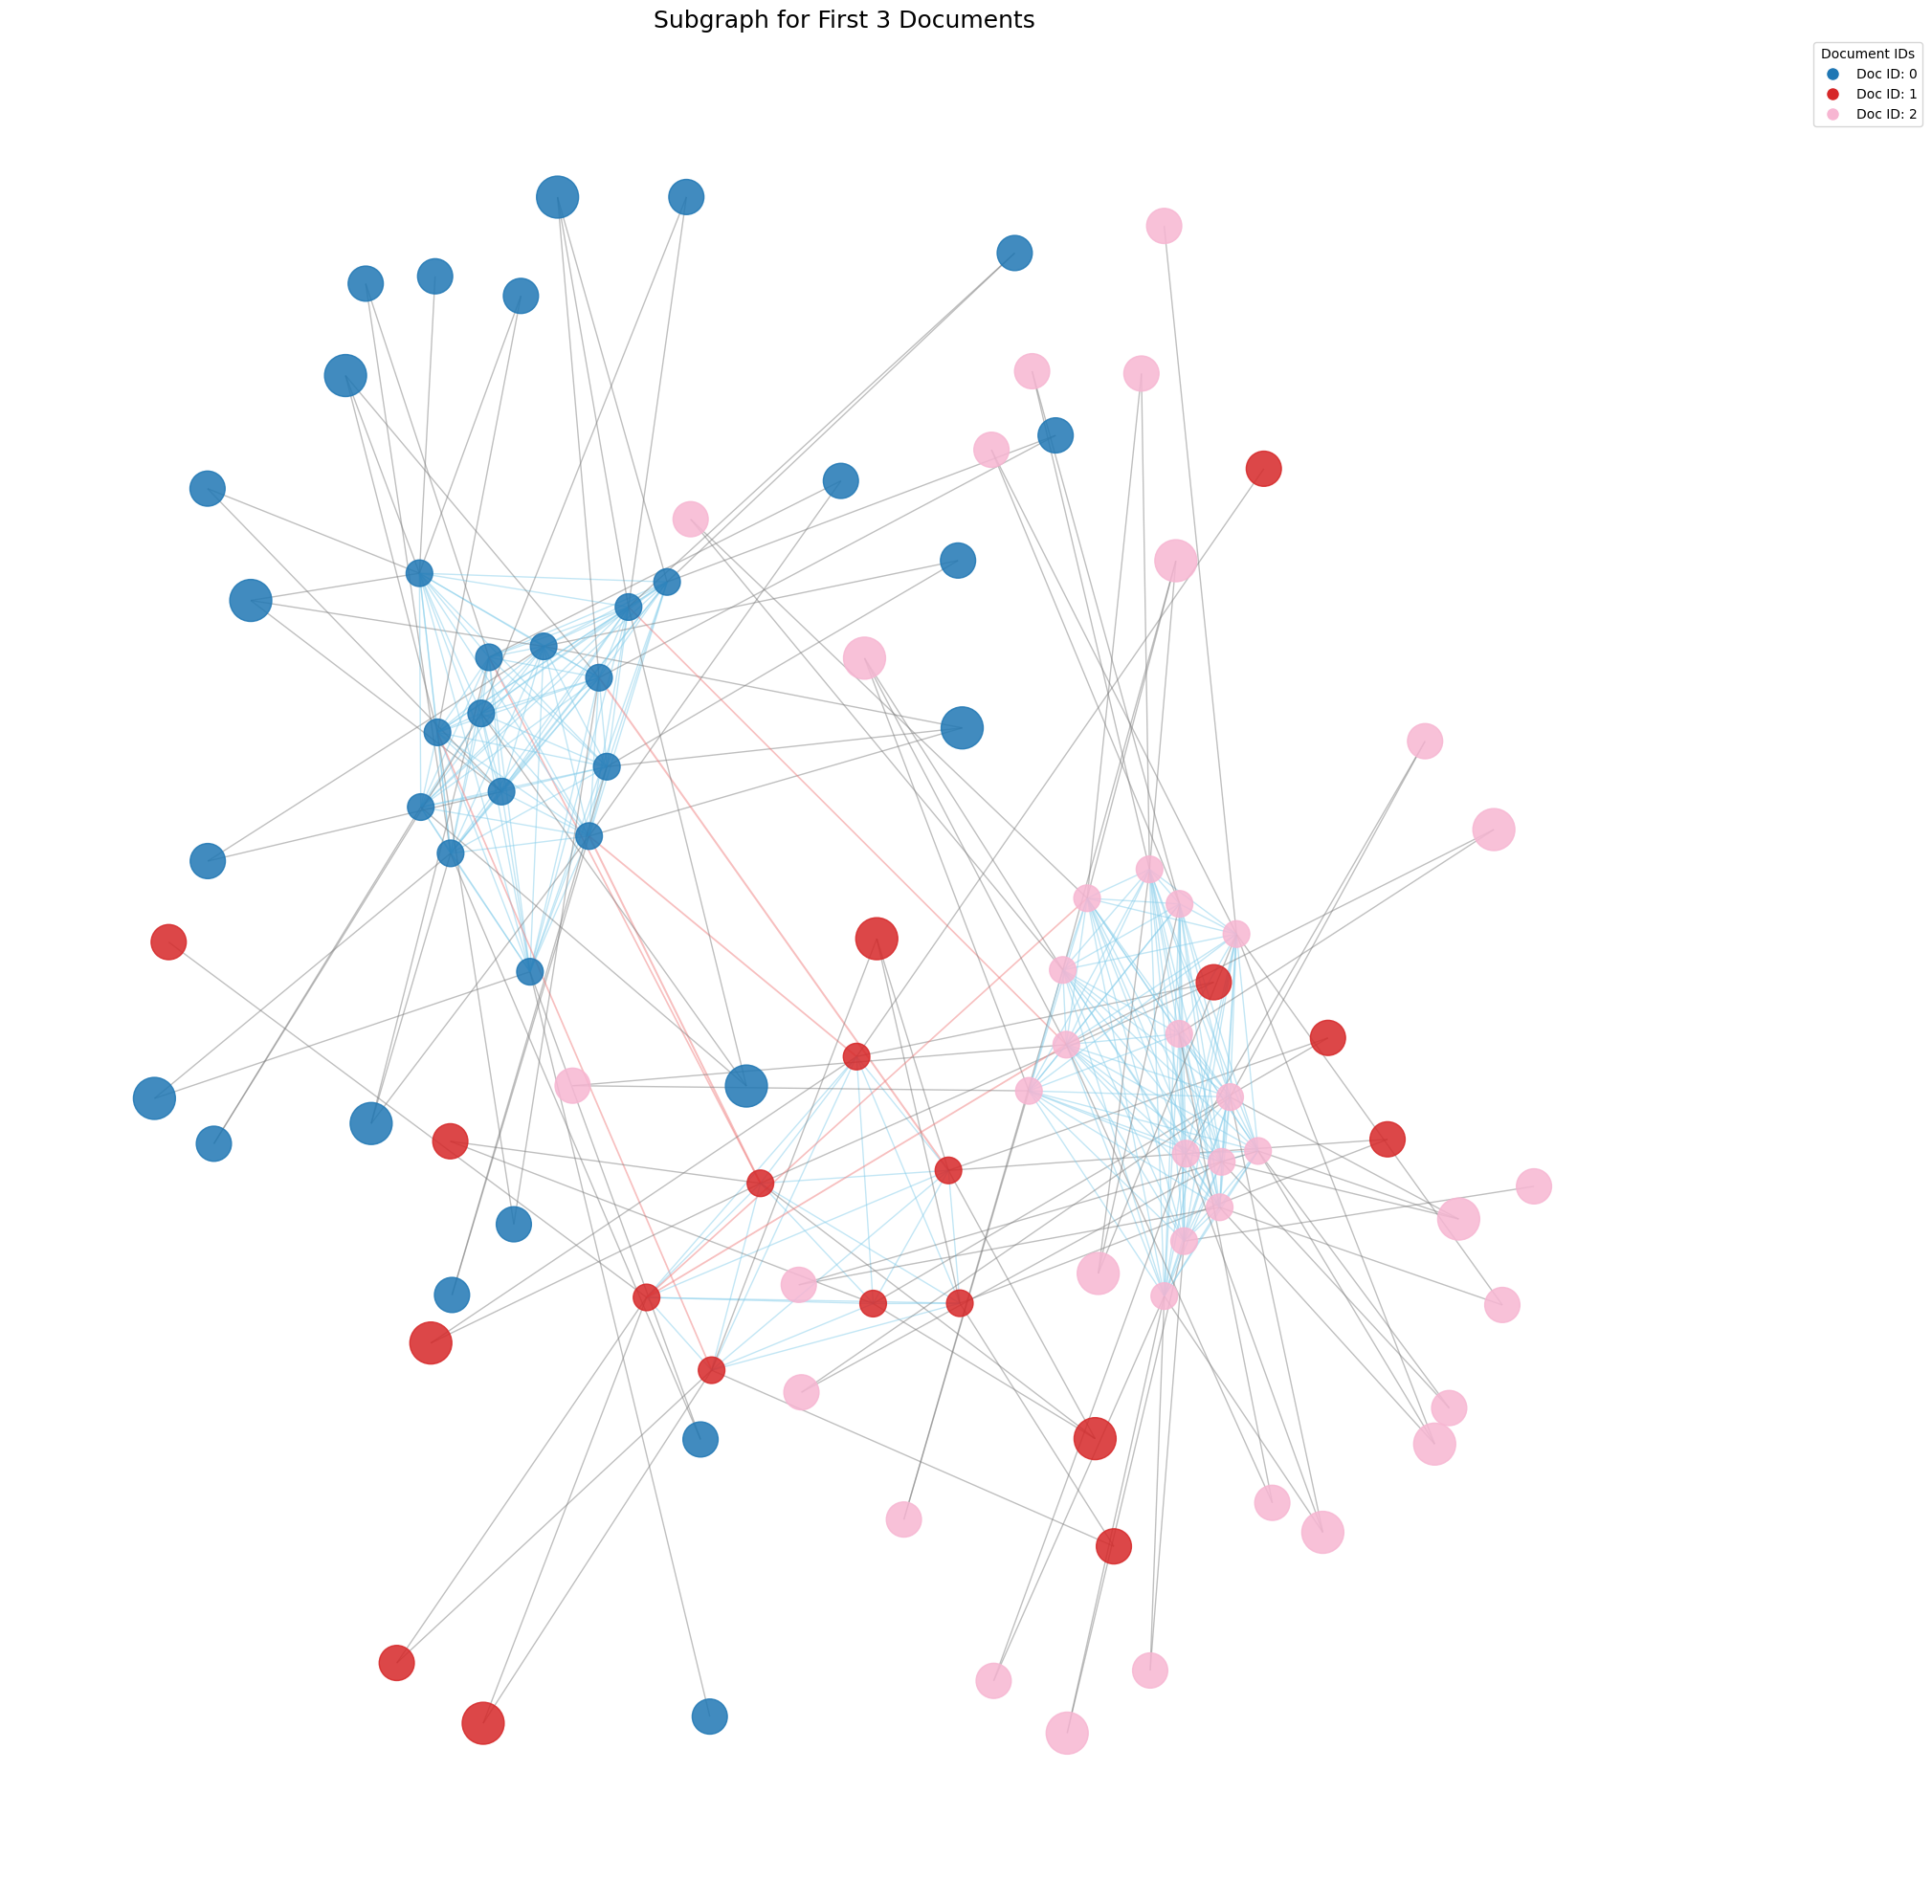

In [22]:

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random

# Ensure the graph G and hybrid_chunks_df are available
if 'G' not in locals() or G.number_of_nodes() == 0:
    print("Graph G is not available or is empty. Please run previous cells to create/load it.")
elif 'hybrid_chunks_df' not in locals() or hybrid_chunks_df.empty:
    print("DataFrame hybrid_chunks_df is not available. Some options might not work.")
else:
    subgraph = None # Initialize subgraph variable
    visualization_title = "Graph Subset Visualization"
    color_nodes_by = 'doc_id' # Default: 'doc_id' or 'level'

    # ================================================================================
    # DEFINE THE NODE OR EDGE SELECTION LOGIC: UNCOMMENT ONE OPTION BLOCK
    # ================================================================================

    # --- OPTION 1: Visualize the first N documents (e.g., first 3) ---
    N_docs = 3
    if 'hybrid_chunks_df' in locals():
        unique_doc_ids = hybrid_chunks_df['doc_id'].unique()
        if len(unique_doc_ids) >= N_docs:
            doc_ids_to_visualize = unique_doc_ids[:N_docs].tolist()
            nodes_to_visualize = [n for n, data in G.nodes(data=True) if data.get('doc_id') in doc_ids_to_visualize]
            subgraph = G.subgraph(nodes_to_visualize)
            visualization_title = f"Subgraph for First {N_docs} Documents"
            color_nodes_by = 'doc_id'
        else:
            print(f"Not enough unique documents to select the first {N_docs}. Found only {len(unique_doc_ids)}.")
    else:
        print("hybrid_chunks_df not available for Option 1.")

    # --- OPTION 2: Visualize all documents of a specific category ---
    # target_category = 'Service Agreement' # Change as needed
    # if 'hybrid_chunks_df' in locals():
    #     doc_ids_for_category = hybrid_chunks_df[hybrid_chunks_df['category'] == target_category]['doc_id'].unique().tolist()
    #     if doc_ids_for_category:
    #         nodes_to_visualize = [n for n, data in G.nodes(data=True) if data.get('doc_id') in doc_ids_for_category]
    #         subgraph = G.subgraph(nodes_to_visualize)
    #         visualization_title = f"Subgraph for Category: {target_category}"
    #         color_nodes_by = 'doc_id'
    #     else:
    #         print(f"No documents found for category: {target_category}")
    # else:
    #     print("hybrid_chunks_df not available for Option 2.")

    # --- OPTION 3: Visualize only 'full_document' level chunks ---
    # nodes_to_visualize = [n for n, data in G.nodes(data=True) if data.get('level') == 'full_document']
    # subgraph = G.subgraph(nodes_to_visualize)
    # visualization_title = "Subgraph of 'full_document' Level Chunks"
    # color_nodes_by = 'doc_id' # Or 'level' if doc_id is not diverse enough

    # --- OPTION 4: Visualize only 'L1' level chunks ---
    # nodes_to_visualize = [n for n, data in G.nodes(data=True) if data.get('level') == 'L1']
    # subgraph = G.subgraph(nodes_to_visualize)
    # visualization_title = "Subgraph of 'L1' Level Chunks"
    # color_nodes_by = 'doc_id' # Or 'level'

    # --- OPTION 5: Visualize only 'semantic_similarity' edges (and their nodes) ---
    # semantic_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('type') == 'semantic_similarity']
    # if semantic_edges:
    #     subgraph = G.edge_subgraph(semantic_edges)
    #     visualization_title = "Subgraph of Semantic Similarity Edges"
    #     color_nodes_by = 'doc_id' # Or 'level'
    # else:
    #     print("No semantic similarity edges found in the graph.")
        
    # --- OPTION 6: Visualize a random sample of N nodes (e.g., 20 nodes) ---
    # N_random_nodes = 20
    # if G.number_of_nodes() >= N_random_nodes:
    #     sampled_nodes = random.sample(list(G.nodes()), N_random_nodes)
    #     subgraph = G.subgraph(sampled_nodes)
    #     visualization_title = f"Subgraph of {N_random_nodes} Random Nodes"
    #     color_nodes_by = 'doc_id' # Or 'level'
    # elif G.number_of_nodes() > 0: # If graph has fewer than N nodes, sample all
    #     sampled_nodes = list(G.nodes())
    #     subgraph = G.subgraph(sampled_nodes)
    #     visualization_title = f"Subgraph of All {G.number_of_nodes()} Nodes (Random Sample)"
    #     color_nodes_by = 'doc_id'
    # else:
    #     print("Graph has no nodes to sample.")
    # THIS IS THE DEFAULT ACTIVE OPTION IF NONE ABOVE ARE UNCOMMENTED

    # --- OPTION 7: Neighborhood of a specific node (e.g., a high-degree node or a known chunk_id) ---
    # target_node_id = None
    # # Example: Find a high-degree node
    # # if G.number_of_nodes() > 0:
    # #    degrees = dict(G.degree())
    # #    if degrees:
    # #        target_node_id = max(degrees, key=degrees.get)
    # # Or set manually: target_node_id = 'your_chunk_id_here'
    #
    # if target_node_id and G.has_node(target_node_id):
    #     neighbor_nodes = list(G.neighbors(target_node_id))
    #     nodes_to_visualize = [target_node_id] + neighbor_nodes
    #     subgraph = G.subgraph(nodes_to_visualize)
    #     visualization_title = f"Neighborhood of Node: {str(target_node_id)[:20]}..."
    #     color_nodes_by = 'level' # Often more informative for neighborhoods
    # elif target_node_id:
    #     print(f"Node {target_node_id} not found in graph.")
    # else:
    #     print("Target node ID not specified or found for Option 7.")

    # ================================================================================
    # PLOTTING LOGIC (uses the 'subgraph' defined by the chosen option)
    # ================================================================================
    if subgraph is not None and subgraph.number_of_nodes() > 0:
        print(f"Plotting: {visualization_title}")
        print(f"Subgraph contains {subgraph.number_of_nodes()} nodes and {subgraph.number_of_edges()} edges.")

        plt.figure(figsize=(20, 20)) # Adjusted size

        try:
            # k might need adjustment based on density. Iterations can be increased for better layout.
            pos = nx.spring_layout(subgraph, k=0.7, iterations=60, seed=42)
        except Exception as e:
            print(f"Spring layout failed ({e}), falling back to random layout.")
            pos = nx.random_layout(subgraph, seed=42)

        # Node colors
        node_colors_list = []
        legend_handles = []
        levels_color_map = {'L1': 'red', 'L2': 'blue', 'L3': 'green', 'full_document': 'purple', 'title': 'orange', 'other': 'grey'}

        if color_nodes_by == 'doc_id':
            unique_doc_ids_in_subgraph = sorted(list(set(data.get('doc_id') for _, data in subgraph.nodes(data=True) if data.get('doc_id') is not None)))
            if len(unique_doc_ids_in_subgraph) > 1 and len(unique_doc_ids_in_subgraph) < 15: # Manageable number for legend
                doc_id_color_map = {doc_id: plt.cm.get_cmap('tab20')(i/len(unique_doc_ids_in_subgraph))
                                    for i, doc_id in enumerate(unique_doc_ids_in_subgraph)}
                for node, data in subgraph.nodes(data=True):
                    node_colors_list.append(doc_id_color_map.get(data.get('doc_id'), 'lightgrey'))
                legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=f"Doc ID: {doc_id}",
                                             markersize=10, markerfacecolor=color)
                                  for doc_id, color in doc_id_color_map.items()]
                plt.legend(handles=legend_handles, title="Document IDs", loc='upper right', bbox_to_anchor=(1.15, 1))
            else: # Fallback to level coloring if too many doc_ids or only one
                color_nodes_by = 'level'

        if color_nodes_by == 'level': # This will also run if doc_id coloring was skipped
            for node, data in subgraph.nodes(data=True):
                node_colors_list.append(levels_color_map.get(data.get('level', 'other'), 'grey'))
            if not legend_handles: # Only create level legend if doc_id legend wasn't made
                legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=level,
                                             markersize=10, markerfacecolor=color)
                                  for level, color in levels_color_map.items()]
                plt.legend(handles=legend_handles, title="Chunk Levels", loc='upper right', bbox_to_anchor=(1.15, 1))
        
        # Node sizes
        node_sizes_list = []
        for node, data in subgraph.nodes(data=True):
            level = data.get('level', 'other')
            size = 300 # default for 'other'
            if level == 'full_document': size = 1500
            elif level == 'L3': size = 1000
            elif level == 'L2': size = 700
            elif level == 'L1': size = 400
            elif level == 'title': size = 500
            node_sizes_list.append(size)

        nx.draw_networkx_nodes(subgraph, pos, node_size=node_sizes_list, node_color=node_colors_list, alpha=0.85)

        # Edge styling
        edge_attributes = nx.get_edge_attributes(subgraph, 'type')
        edge_color_map = {
            'hierarchical_child_to_parent': 'gray',
            'hierarchical_parent_to_child': 'darkgray',
            'same_document_l1': 'skyblue',
            'semantic_similarity': 'lightcoral',
            'default': 'lightgrey' # Default for edges with no type or unknown type
        }
        
        edge_colors_list = []
        edge_widths_list = []

        for u, v, data in subgraph.edges(data=True):
            edge_type = data.get('type', 'default')
            edge_colors_list.append(edge_color_map.get(edge_type, edge_color_map['default']))
            if edge_type == 'semantic_similarity':
                edge_widths_list.append(data.get('weight', 0.5) * 2) # Scale semantic weight for visibility
            else:
                edge_widths_list.append(1.0)


        nx.draw_networkx_edges(subgraph, pos, width=edge_widths_list, alpha=0.5, edge_color=edge_colors_list)

        # Node Labels (optional, can be very cluttered)
        # Consider only labeling certain nodes or using shorter IDs
        node_labels_dict = {n: str(data.get('chunk_id', n))[:15] + "..." if len(str(data.get('chunk_id', n))) > 15 else str(data.get('chunk_id',n))
                           for n, data in subgraph.nodes(data=True)}
        # nx.draw_networkx_labels(subgraph, pos, labels=node_labels_dict, font_size=7, alpha=0.8)

        plt.title(visualization_title, fontsize=18)
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    elif subgraph is None:
        print("No visualization option was selected or an error occurred in selection.")
    else: # subgraph is not None but has 0 nodes
        print(f"The selected criteria for '{visualization_title}' resulted in an empty subgraph (0 nodes). Nothing to plot.")


## Minor Enhancements to Consider

The following improvements are **optional** and **not critical**, but they can make your graph processing more robust and scalable if you plan to expand this project further.

### 1. Edge Deduplication Across Edge Types
While you already check for duplicate edges within a single type, you might want to prevent **different edge types** from redundantly connecting the same nodes.  
This can avoid inflated graph connectivity when performing certain algorithms.

---

### 2. Weight Normalization
Currently, hierarchical edges have a fixed weight of `1.0`, and semantic similarity edges use cosine similarity scores.  
If you plan to **mix edge types** in weighted algorithms (e.g., PageRank, shortest path), consider **normalizing or scaling** these weights consistently.

---

### 3. Edge Type Conflict Checks
Add optional **warnings or logs** when adding an edge if a **different edge type already exists** between the same node pair.  
This helps you **track potential logical conflicts** in the graph structure.

---

### 4. Top-k Semantic Similarity Filtering
If you **scale to very large graphs**, connecting all nodes that exceed the similarity threshold may create **too many edges**.  
Instead, you can **limit connections to the top-k most similar nodes** to control graph density.

---

### 5. Progress Indicators
For **larger datasets**, adding **progress bars** (e.g., with `tqdm`) can make long-running computations more user-friendly by showing **real-time progress**.

---

### 6. Graph Export for Visualization or Reuse
Consider adding options to **export the graph** in formats like:
- `.graphml` or `.gexf` (for Gephi or Cytoscape)
- `.gpickle` (for reloading in Python)

Example:
```python
nx.write_graphml(G, "document_graph.graphml")


### 5.2. Introduction to GNN Training

**What are Graph Neural Networks (GNNs)?**
Graph Neural Networks (GNNs) are a type of neural network designed to work directly with graph-structured data. They learn by aggregating information from a node's neighbors. This allows them to capture complex relationships and dependencies within the graph.

**Why use GNNs for your project?**
1.  **Contextual Understanding:** GNNs can understand the context of a legal clause (a node) by considering its relationship with other clauses, sections, or the entire document (neighboring nodes and the graph structure).
2.  **Relationship Learning:** They can learn the importance of different types of relationships (e.g., hierarchical vs. semantic similarity) and how they contribute to the meaning or function of a clause.
3.  **Improved Information Retrieval:** For tasks like finding relevant clauses or answering questions about a contract, GNNs can provide more accurate results than methods that treat text in isolation because they leverage the learned graph structure.
4.  **Sophistication:** As you mentioned, GNNs can "sophisticate" the graph by learning richer representations (embeddings) for each node that incorporate both its own content and its graph neighborhood. These learned embeddings can then be used for various downstream tasks.

**Preparing Graph Data for GNNs:**
1.  **Node Features:** Each node in the graph needs an initial feature vector. In our case, the pre-computed SBERT embeddings for each chunk (`row['embedding']`) are excellent initial node features.
2.  **Adjacency Matrix (or Edge List):** The GNN needs to know how nodes are connected. This is typically represented as an adjacency matrix or an edge list. `NetworkX` graphs can be easily converted to these formats.
3.  **Edge Features (Optional):** Edges can also have features (e.g., `type` of relationship like 'hierarchical' or 'semantic_similarity', or `weight` like the cosine similarity score). These can provide additional information to the GNN.
4.  **Labels (for Supervised Learning):** If you have a specific task in mind (e.g., classifying clauses, predicting links between clauses), you'll need labels for your nodes or edges to train the GNN in a supervised manner.

**Conceptual Overview of GNN Training:**
1.  **Message Passing:** The core idea of many GNNs is message passing. Each node sends "messages" (usually derived from its features) to its neighbors. 
2.  **Aggregation:** Each node then aggregates the messages received from its neighbors (e.g., by summing or averaging them).
3.  **Update:** The node updates its own feature vector (embedding) based on its current features and the aggregated messages. This process is typically done through learnable neural network layers.
4.  **Stacking Layers:** Multiple message passing layers can be stacked. With each layer, a node gathers information from further away in the graph (its k-hop neighborhood).
5.  **Loss Calculation & Backpropagation:** For a supervised task, a loss function is defined based on the GNN's output (e.g., predicted class for a node) and the true labels. The loss is then backpropagated to update the GNN's weights.

**Popular GNN Libraries:**
-   **PyTorch Geometric (PyG):** Built on PyTorch, very popular and comprehensive.
-   **Deep Graph Library (DGL):** Framework-agnostic (supports PyTorch, TensorFlow, MXNet).
-   **Spektral:** Built on TensorFlow/Keras.

In the next steps, we would typically choose a GNN library, convert our `NetworkX` graph into the required format, define a GNN model architecture, and then train it for a specific task (e.g., node classification, link prediction, or graph classification). Since we don't have explicit labels yet for a supervised task, we might first explore unsupervised GNNs (like Graph Autoencoders) to learn better node embeddings or prepare for a downstream supervised task once labels are available.